This code is adapted from Marina's NuMI $\nu_e$ and $\bar{\nu}_e$ xsec analysis for the use of a similar NuMI $\nu_\mu$ and $\bar{\nu}_\mu$ xsec analysis. 

There are two stages:
* Separate $\nu_\mu$ and $\bar{\nu}_\mu$ by trainin a BDT, based on the BDT Marina developed for her analysis.
* Then, individual $\nu_\mu$ and $\bar{\nu}_\mu$ xsec will be measure using MicroBooNE off-axis NuMI beam data (run 1 and 3)

In [1]:
#====================#
#  Import Packages   #
#====================#

import math 
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

# BDT
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import xgboost as xgb
from matplotlib.pylab import rcParams

/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):


### Function Definitions

In [2]:
#===========================================#
#  Define the boundaries of the TPCc volume #
#===========================================#

tpc_xmin = -1.55
tpc_xmax = 254.8
tpc_ymin = -115.53
tpc_ymax = 117.47
tpc_zmin = 0.1
tpc_zmax = 1036.9

In [3]:
#========================================================#
#  A function for creating dataframes and importing data #
#  from root files                                       #
#========================================================#
def new_df(file, fType, pot_data, pot_ext, pot_mc, pot_dirt):
    
    
    #—————————————————————————————————————————————————
    # First, define variables needed from the WC trees
    #—————————————————————————————————————————————————
    
    
    #reco vars
    eval_vars_reco = ['flash_time', 'match_isFC']
    pfeval_vars_reco = ['reco_nuvtxX','reco_nuvtxY', 'reco_nuvtxZ', 'run', 'subrun',
                        'event', 'reco_muonMomentum', 'reco_showerKE']
    bdt_vars_reco = ['numu_cc_flag', 'gap_energy', 'gap_flag_single_shower','gap_flag', 'showervtx_diff']
    kine_vars_reco = ['kine_reco_Enu', 'kine_pio_mass','kine_pio_flag','kine_pio_vtx_dis',
                      'kine_pio_energy_1','kine_pio_energy_2','kine_pio_dis_1',
                      'kine_pio_dis_2','kine_pio_angle'] #pi0 selection
    
    #true vars
    kine_vars_true = []
    bdt_vars_true = []
    pfeval_vars_true = ['truth_corr_nuvtxX', 'truth_corr_nuvtxY', 'truth_corr_nuvtxZ', 
                        'truth_nuIntType', 'truth_pdg', 'truth_NprimPio']
    eval_vars_true = ['weight_cv', 'weight_spline', 'truth_nuPdg', 'truth_isCC', 
                      'truth_nuEnergy','truth_vtxX', 'truth_vtxY', 'truth_vtxZ',
                      'match_completeness_energy', 'truth_energyInside', 'truth_vtxInside']
    
    
    #————————————————————————————————————
    # import the trees from the root file
    #————————————————————————————————————
    
    
    T_eval = uproot.open(file)['wcpselection/T_eval']
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    T_BDTvars = uproot.open(file)['wcpselection/T_BDTvars']
    T_KINEvars = uproot.open(file)['wcpselection/T_KINEvars']

    
    #———————————————————————————————————————————————————
    # for each tree, create a reco and a true data frame
    #———————————————————————————————————————————————————
    
    
    #Reco dfs
    df_eval_reco = T_eval.pandas.df(eval_vars_reco, flatten=False)
    df_PFeval_reco = T_PFeval.pandas.df(pfeval_vars_reco, flatten=False)
    df_BDTeval_reco = T_BDTvars.pandas.df(bdt_vars_reco, flatten=False)
    df_KINEvars_reco =T_KINEvars.pandas.df(kine_vars_reco, flatten=False)
    
    #use concat to merge the individual reco dataframes
    df_ = pd.concat([df_KINEvars_reco, df_BDTeval_reco, df_PFeval_reco, 
                     df_eval_reco], axis=1)
    
    #true dfs
    if((fType=='MC') | (fType=='DIRT')):
        
        #for each tree, create a true data frame
        df_eval_true = T_eval.pandas.df(eval_vars_true, flatten=False)
        df_PFeval_true = T_PFeval.pandas.df(pfeval_vars_true, flatten=False)
        df_BDTeval_true = T_BDTvars.pandas.df(bdt_vars_true, flatten=False)
        df_KINEvars_true =T_KINEvars.pandas.df(kine_vars_true, flatten=False)
        
        #use concat to merge the individual dataframes
        df_ = pd.concat([df_, df_KINEvars_true, df_BDTeval_true, df_PFeval_true, 
                         df_eval_true], axis=1)
        
        #fix vars, make sure they have reasonable values (weight_cv & weight_spline)
        df_['weight_cv'] = np.where((df_.weight_cv <= 0), 1, df_.weight_cv)
        df_['weight_cv'] = np.where((df_.weight_cv > 30), 1, df_.weight_cv)
        df_['weight_cv'] = np.where((df_.weight_cv == np.nan), 1, df_.weight_cv)
        df_['weight_cv'] = np.where((df_.weight_cv == np.inf), 1, df_.weight_cv)
        df_['weight_cv'] = np.where((df_['weight_cv'].isna()), 1, df_.weight_cv)
        df_['weight_spline'] = np.where((df_.weight_spline <= 0), 1, df_.weight_spline)
        df_['weight_spline'] = np.where((df_.weight_spline > 30), 1, df_.weight_spline)
        df_['weight_spline'] = np.where((df_.weight_spline == np.nan), 1, df_.weight_spline)
        df_['weight_spline'] = np.where((df_.weight_spline == np.inf), 1, df_.weight_spline)
        df_['weight_spline'] = np.where((df_['weight_spline'].isna()), 1, df_.weight_spline)
        
    
    #————————————————
    # only impose FHC
    #————————————————
    
    
    df_ = df_[df_.run<6748]
    
    
    #————————————————————————
    # calculate event weights
    #————————————————————————
    
    
    if(fType=='MC'):
        W_ = pot_data/pot_mc
        df_.loc[:,'weight_genie'] = df_['weight_cv'] * df_['weight_spline']
        df_.loc[:,'weight_ubtune'] = [W_]*df_.shape[0] * df_['weight_genie']
        df_.loc[:,'weight_no_ubtune'] = [W_]*df_.shape[0] * df_['weight_spline']
    elif(fType=='DATA'): #for beam-on sample
        W_ = 1
        df_.loc[:,'weight_ubtune'] = [W_]*df_.shape[0]
    elif(fType=='EXT'): #for beam-off sample
        W_ = (pot_data/pot_ext)*0.98
        df_.loc[:,'weight_ubtune'] = [W_]*df_.shape[0]
    elif(fType=='DIRT'):
        W_ = pot_data/pot_dirt
        df_.loc[:,'weight_genie'] = df_['weight_cv'] * df_['weight_spline']
        df_.loc[:,'weight_ubtune'] = [W_]*df_.shape[0] * df_['weight_genie']
        df_.loc[:,'weight_no_ubtune'] = [W_]*df_.shape[0] * df_['weight_spline']
        

    #—————————————————————#
    # add extra variables #
    #—————————————————————#
    
    df_ = calc_costheta(df_)
    if ( (fType=='DATA') | (fType=='MC') | (fType=='DIRT') ):
        df_ = calc_particle_multiplicity(file, df_)
    
    #————————————————————————————————————————————
    # For beam-on/off data, apply a quality check
    #————————————————————————————————————————————
    
    
    if((fType=='DATA') | (fType=='EXT')):
        df_good_runs = pd.read_csv('run1_beamon_goodquality.list', 
                sep=", ", header=None, engine='python')
        df_good_runs = df_good_runs.T
        df_good_runs.rename(columns={0:'run'}, inplace=True)
        list_good_runs = df_good_runs['run'].values.tolist()
        df_ = df_[df_['run'].isin(list_good_runs)]
        
        
    
    #—————————————————————————————————————————————————————————————————
    # fix neutrino energy for data
    # the neutrino reconstructed energy needs to be corrected for data
    # tot_energy = shower_energy + track_energy
    # and the shower_energy needs a 95% correction factor
    #————————————————————————————————————————————————————————————————— 
    
    
    if(fType=='DATA'):
        def get_data_nuEnergyCorrected(df_, file):
            
            df_in = df_.copy()

            # create dataframe with relevant information to 
            # calculate DATA neutrino energy
            tree = uproot.open(file)['wcpselection/T_KINEvars']
            var = ['kine_energy_particle', 'kine_energy_info', 'kine_particle_type', 
                   'kine_reco_add_energy', 'kine_reco_Enu']
            df_temp = tree.pandas.df(var, flatten = True)

            # apply cuts and define new dataframes
            df_temp = df_temp[ df_temp.kine_reco_Enu>0 ]
            df_EM = df_temp[ (df_temp.kine_energy_info==2) \
                            & (df_temp.kine_particle_type==11) ] # shower
            df_track = df_temp[ (df_temp.kine_energy_info!=2) \
                               | (df_temp.kine_particle_type!=11) ] # track

            # apply 95% correction on EM
            df_EM.loc[:,'kine_energy_particle'] = df_EM['kine_energy_particle']\
                                                .apply(lambda x: x*0.95)

            df_temp.loc[:,'energy_EM'] = df_EM.groupby(['entry'])['kine_energy_particle']\
                                        .transform('sum')
            df_temp.loc[:,'energy_track'] = df_track.groupby(['entry'])\
                                        ['kine_energy_particle'].transform('sum')

            df_temp['energy_EM'].fillna(0, inplace=True)
            df_temp['energy_track'].fillna(0, inplace=True)

            df_temp['energy_EM'] = df_temp.groupby(['entry'])['energy_EM'].transform(max)
            df_temp['energy_track'] = df_temp.groupby(['entry'])['energy_track']\
                                        .transform(max)

            df_temp = df_temp.groupby('entry').first()

            df_temp['kine_reco_Enu_corr'] = df_temp['energy_EM'] + df_temp['energy_track'] \
                                            + df_temp['kine_reco_add_energy']
            df_temp = df_temp.drop(['kine_energy_particle','kine_energy_info',
                                    'kine_particle_type','kine_reco_add_energy',
                                    'kine_reco_Enu','energy_EM','energy_track'], axis=1)
            df_temp = df_temp.rename(columns={"kine_reco_Enu_corr":"kine_reco_Enu"})

            df_in.update(df_temp)
            return df_in

            df_ = get_data_nuEnergyCorrected(df_.copy(),File)
    
    
    #—————————————
    # add RSE info
    #—————————————
    
    
    df_['RSE'] = df_["run"].astype(int).apply(str) + "_" \
                + df_["subrun"].astype(int).apply(str) + "_" \
                + df_["event"].astype(int).apply(str)
    
    
    #——————————————————————
    # Print POT and Entries
    #——————————————————————
    
    
    if(fType=='MC'):
        print('[%s] POT %5.2e      %7i entries' % (fType,pot_mc,len(df_)))
    elif(fType=='DATA'): #for beam-on sample
        print('[%s] POT %5.2e      %7i entries' % (fType,pot_data,len(df_)))
    elif(fType=='EXT'): #for beam-off sample (TBC the pot calc)
        print('[%s] POT %5.2e      %7i entries' % (fType,pot_ext,len(df_)))
    elif(fType=='DIRT'):
        print('[%s] POT %5.2e      %7i entries' % (fType,pot_dirt,len(df_)))
    return df_

In [4]:
#=================================#
#  A Function used to create pot  #
#=================================#
def calc_pot(file, fType):
    
    
    #—————————————————————
    #create necessary vars
    #—————————————————————
    
    
    if(fType=='MC'):
        pot_vars = ['runNo','pot_tor875']
    elif(fType=='DIRT'):
        pot_vars = ['run','pot_tor875']
    
    
    #——————————————————————————————————————
    #import the pot tree from the root file
    #——————————————————————————————————————
    
    
    T_pot = uproot.open(file)['wcpselection/T_pot']
    
    
    #———————————————————————————
    #Create a pd df for pot tree
    #———————————————————————————
    
    
    df_pot = T_pot.pandas.df(pot_vars, flatten=False)
    
    #only impose FHC
    if(fType=='MC'):
        df_pot = df_pot[df_pot.runNo<6748]
    elif(fType=='DIRT'):
        df_pot = df_pot[df_pot.run<6748]
    
    
    #—————————————————
    #Calculate the pot
    #—————————————————
    
    
    pot = sum(df_pot.pot_tor875)
    return pot

In [5]:
#================================================================================#
# A Function for calculating the angle b/w numi beam target and muon from vertex #
#================================================================================#

def calc_costheta(df):
    
    # position of the NuMI target
    # those values are manually added to the lines below
    # if you want to change them, make sure you also update the lines below!!
    v_targ_uboone = [-31387.58422, -3316.402543, -60100.2414]

    # take the vector from the NuMI target to the neutrino vertex
    df.eval('vec_targ_vtx_X = reco_nuvtxX - (-31387.58422)', inplace=True)
    df.eval('vec_targ_vtx_Y = reco_nuvtxY - (-3316.402543)', inplace=True)
    df.eval('vec_targ_vtx_Z = reco_nuvtxZ - (-60100.2414)', inplace=True)
    
    # get reco shower vector (workaround that is working, for some reason I can't access it if I don't do this workaround, maybe it's somethind to do with the name containing [ ])
    df.loc[:,'muon_momentum_X'] = df["reco_muonMomentum[0]"]
    df.loc[:,'muon_momentum_Y'] = df["reco_muonMomentum[1]"]
    df.loc[:,'muon_momentum_Z'] = df["reco_muonMomentum[2]"]
    df.loc[:,'muon_energy'] = df["reco_muonMomentum[3]"]
    
    # calculate the norm of the vectors
    df.eval('norm_vec_targ_vtx = sqrt(vec_targ_vtx_X**2 + vec_targ_vtx_Y**2 + vec_targ_vtx_Z**2)', inplace=True)
    df.eval('norm_vec_shower = sqrt(muon_momentum_X**2 + muon_momentum_Y**2 + muon_momentum_Z**2)', inplace=True)
    
    # calculate cos_theta
    df.eval('cos_theta = ((vec_targ_vtx_X * muon_momentum_X) + (vec_targ_vtx_Y * muon_momentum_Y) + (vec_targ_vtx_Z * muon_momentum_Z) )/(norm_vec_targ_vtx * norm_vec_shower)', inplace=True)

    return df

In [6]:
#=========================================#
# A Function for calculating multiplicity #
#=========================================#

def calc_particle_multiplicity(filename, df_original):

    # --- open file and variables
    pfeval_particle = ['reco_mother','reco_pdg','reco_Ntrack', 'run', 'subrun', 'event']
    T_PFeval = uproot.open(filename)['wcpselection/T_PFeval']
    DF = T_PFeval.pandas.df(pfeval_particle, flatten=True)

    # --- queries to split into different variables
    df_Neutron = DF.query('((reco_pdg==2112) | (reco_pdg==-2112)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Neutron.groupby(['entry'])['reco_pdg'].transform('count')

    df_Muon = DF.query('((reco_pdg==13) | (reco_pdg==-13)) & reco_mother==0')
    DF.loc[:,'countMuon'] = df_Muon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Kaon = DF.query('((reco_pdg==321) | (reco_pdg==-321)) & reco_mother==0')
    DF.loc[:,'countKaon'] = df_Kaon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Pion = DF.query('((reco_pdg==211) | (reco_pdg==-211)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Pion.groupby(['entry'])['reco_pdg'].transform('count')

    df_Proton = DF.query('((reco_pdg==2212) | (reco_pdg==-2212)) & reco_mother==0')
    DF.loc[:,'countProton'] = df_Proton.groupby(['entry'])['reco_pdg'].transform('count')

    df_Gamma = DF.query('((reco_pdg==22) | (reco_pdg==-22)) & reco_mother==0')
    DF.loc[:,'countGamma'] = df_Gamma.groupby(['entry'])['reco_pdg'].transform('count')

    df_Electron = DF.query('((reco_pdg==11) | (reco_pdg==-11)) & reco_mother==0')
    DF.loc[:,'countElectron'] = df_Electron.groupby(['entry'])['reco_pdg'].transform('count')

    df_concat = DF

    # --- create an extra column with the max number in the count... column
    df_concat.loc[:,'Num_Neutron'] = df_concat.groupby(['entry'])['countNeutron'].transform('max')
    df_concat.loc[:,'Num_Muon'] = df_concat.groupby(['entry'])['countMuon'].transform('max')
    df_concat.loc[:,'Num_Kaon'] = df_concat.groupby(['entry'])['countKaon'].transform('max')
    df_concat.loc[:,'Num_Proton'] = df_concat.groupby(['entry'])['countProton'].transform('max')
    df_concat.loc[:,'Num_Gamma'] = df_concat.groupby(['entry'])['countGamma'].transform('max')
    df_concat.loc[:,'Num_Electron'] = df_concat.groupby(['entry'])['countElectron'].transform('max')

    # --- get the first subentry only --> the same as unflatten the dataframe
    df_concat.groupby('entry').first()

    # --- create the final dataframe with the columns that we want
    df_final = df_concat[['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron', 'run', 'subrun', 'event']].groupby('entry').first()
    df_final = df_final.fillna(0)

    # --- merge with the original dataframe
    df_final = pd.merge(df_original, df_final, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')

    return df_final

### Event Selection Functions

In [7]:
#===============================================================#
# A Function for clearing non-physical values for reco vertices #
#===============================================================#


def reco_nu_vtx_val_clearing(df):
    df_ = df.query('reco_nuvtxX != -1 & reco_nuvtxY != -1 & reco_nuvtxZ != -1')
    return df_

In [8]:
#===========================================#
# A Function for Generic Neutrino Selection #
#===========================================#


def gen_nu_selec(df):
    selec_df = df[df.numu_cc_flag >= 0]
    return selec_df

In [9]:
#=================================#
# A Function for numuCC selection #
#=================================#
def numuCC(df):
    selec_df = df[df.numu_cc_flag >= 1]
    return selec_df

In [10]:
#======================================================#
# Add Geometry vars containing Fiducial Vol Boundaries #
#======================================================#
fv_xmin = tpc_xmin+7.55
fv_xmax = tpc_xmax-3.
fv_ymin = tpc_ymin+3.
fv_ymax = tpc_ymax-3.
fv_zmin = tpc_zmin+3.
fv_zmax = tpc_zmax-3.

In [11]:
#===========================================#
#  A Function for Fiducial Volume Selection #
#===========================================#


def apply_inFV(df):
    df_ = df[((df.reco_nuvtxX>(fv_xmin)) & (df.reco_nuvtxX<(fv_xmax))) &
             ((df.reco_nuvtxY>(fv_ymin)) & (df.reco_nuvtxY<(fv_ymax))) & 
             ((df.reco_nuvtxZ>(fv_zmin)) & (df.reco_nuvtxZ<(fv_zmax)))]    
    return df_

In [12]:
#=========================================================#
#  A Function for Containment Selection (Fully contained) #
#=========================================================#


def apply_isFC(df):
    selec_df = df[df.match_isFC==1]
    return selec_df

In [13]:
#============================================================#
# A Function for Containment Selection (Partially contained) #
#============================================================#


def apply_notFC(df):
    selec_df = df[df.match_isFC==0]
    return selec_df

In [14]:
#============================================================#
# A Function for selecting problematic range for closer look #
#============================================================#

def problem_Enu_range(df):
    selec_df = df.query('kine_reco_Enu>=150. & kine_reco_Enu<=650.')
    return selec_df

In [15]:
#=======================================================#
# A Function for selecting events with bad angle values #
#=======================================================#

def problem_angle_val(df):
    df_ = df.query('cos_theta<-0.8 & cos_theta>-0.84')
    return df_

In [16]:
#========================================#
# A Function for applying selection cuts #
#========================================#


def applyCuts(label, dfData, dfEXT, dfOverlay, dfDirt, weight, print_lengths, POT_data, plotCondition='default'):
    print('\n---------- Applying: %s\n' % label)


    #—————————————#
    # Apply cuts  #
    #—————————————#


    if (label=='None'):                 # No selection applied
        df_data = dfData
        df_mc = dfOverlay
        df_ext = dfEXT
        df_dirt = dfDirt
    # elif (label=='recoVtxTrim'):         # Trim down badly reconstructed vertex values
    #     df_data = reco_nu_vtx_val_clearing(dfData)
    #     df_mc = reco_nu_vtx_val_clearing(dfOverlay)
    #     df_ext = reco_nu_vtx_val_clearing(dfEXT)
    #     df_dirt = reco_nu_vtx_val_clearing(dfDirt)
    elif (label=='genNuSelection'):      # Generic Neutrino Selection and numuCC selection
        df_data = gen_nu_selec(dfData)
        df_mc = gen_nu_selec(dfOverlay)
        df_ext = gen_nu_selec(dfEXT)
        df_dirt = gen_nu_selec(dfDirt)
    elif (label=='fiducialVol'):         # Fiducial volume selection
        df_data = apply_inFV(dfData)
        df_mc = apply_inFV(dfOverlay)
        df_ext = apply_inFV(dfEXT)
        df_dirt = apply_inFV(dfDirt)
    elif (label=='numuCCCut'):      # Generic Neutrino Selection and numuCC selection
        df_data = numuCC(dfData)
        df_mc = numuCC(dfOverlay)
        df_ext = numuCC(dfEXT)
        df_dirt = numuCC(dfDirt)
    elif (label=='problematicEnu'):
        df_data = problem_Enu_range(dfData)
        df_mc = problem_Enu_range(dfOverlay)
        df_ext = problem_Enu_range(dfEXT)
        df_dirt = problem_Enu_range(dfDirt)

    if(print_lengths==True):
        print('[DATA] %7i entries' % sum(df_data[weight]))
        print('[EXT]  %7i entries' % sum(df_ext[weight]))
        print('[MC]   %7i entries' % sum(df_mc[weight]))
        print('[DIRT]   %7i entries' % sum(df_dirt[weight]))

    # make stacked histograms
    plots_for_SelectionCuts(df_data, df_ext, df_mc, df_dirt, weight, label, POT_data, plotCondition)
        
    # return the updated dataframes
    return df_data, df_ext, df_mc, df_dirt

### MC Topology Classification Functions

In [17]:
def isCosmic(df):
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) \
               | (df.truth_energyInside <= 0))]
    # print('Number of rows BEFORE query: %s' % len(df))
    # df_ = df.query('match_completeness_energy <= truth_energyInside*0.1 \
    #                       | truth_energyInside <= 0')
    # print('Number of rows AFTER query: %s' % len(df_))
    return df_

def notCosmic(df):
    df_ = df[~((df.match_completeness_energy <= df.truth_energyInside * 0.1) \
               | (df.truth_energyInside <= 0))]
    # print('Number of rows BEFORE query: %s' % len(df))
    # df_ = df.query('match_completeness_energy > truth_energyInside*0.1 \
    #                & truth_energyInside > 0')
    # print('Number of rows AFTER query: %s' % len(df_))
    return df_

def isOutFV(df):
    df_ = df[(df.truth_vtxInside==0)]  
    # print('Number of rows BEFORE query: %s' % len(df))
    # df_ = df.query('truth_vtxInside==0')                          # vtx outFV
    # print('Number of rows AFTER query: %s' % len(df_))
    return df_

def notOutFV(df):
    df_ = df[(df.truth_vtxInside != 0)]
    return df_

def isNue_NuebarCC(df):
    df_ = df[((df.truth_nuPdg==12) | (df.truth_nuPdg==-12))    
             & (df.truth_isCC==1)] 
    # df_ = df.query('truth_nuPdg==12 | truth_nuPdg==-12')                            # nue/nue_barCC
    return df_

def isNumuCC(df):
    df_ = df[(df.truth_nuPdg==14) &                             
             (df.truth_isCC==1)] 
    # df_ = df.query('truth_nuPdg==14 & \
    #                truth_isCC==1')                               # numu CC
    return df_

def isNumu_barCC(df):
    # df_ = df[(df.truth_nuPdg==-14) &                             
    #          (df.truth_isCC==1)]  
    df_ = df.query('truth_nuPdg==-14 & \
                   truth_isCC==1')                               # numu_barCC
    return df_

def isNCpi(df):
    mask_pi = np.array([211 in array for array in np.abs(np.array(df.truth_pdg))])
    mask_isNC = df.truth_isCC==0                                 # NC with charged pions
    df_ = df[mask_isNC & mask_pi]
    #df_ = df.query('(truth_pdg==211 | truth_pdg==-211) & truth_isCC==0')
    return df_

def isNC(df):
    mask_no_pi = np.array([not 211 in array for array in np.abs(np.array(df.truth_pdg))])
    mask_isNC = df.truth_isCC==0
    df_ = df[mask_isNC & mask_no_pi]                             # NC with no pions
    # df_ = df.query('(truth_pdg!=211 | truth_pdg!=-211) & truth_isCC==0')
    return df_

In [18]:
#—————————————————————
#Test cell for mask_pi
#—————————————————————

# #criterion = []
# for idx, subarray in enumerate(test_df["truth_pdg"]):
#     criterion.append(int((211) in np.abs(subarray)))

# print(f"Number of entries: {test_df['truth_pdg'].count()}")
# print(f"Entries with 211: {sum(criterion)}")
# print('Number of NC: %s' % test_nc['truth_pdg'].count())

### Funtions for Plotting

In [19]:
#=============================================#
#  Functions setting vars to plot after cuts  #
#=============================================#


def plots_for_SelectionCuts(df_data, df_ext, df_overlay, df_dirt, weight, label, POT_data, condition='default'):
    
    # this function makes all the plots that you want to plot throughout the pre-selection cuts
    
    if (condition=='default'):
        # --- MC/DATA comparison
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxX", weight, \
                            "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", \
                            tpc_xmin, tpc_xmax, 25, POT_data)
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxX", weight, \
                            "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", \
                            245, tpc_xmax, 30, POT_data)
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxY", weight, \
                            "plots/%s_nuvtxY" % label, "Reco neutrino Vertex Y [cm]", \
                            tpc_xmin, tpc_ymax, 25, POT_data)
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxZ", weight, \
                            "plots/%s_nuvtxZ" % label, "Reco neutrino Vertex Z [cm]", \
                            tpc_zmin, tpc_zmax, 25, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "flash_time", weight, \
                            "plots/%s_flash_time" % label, r"Flash Time [$\mu$s]", \
                            4, 18, 1, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "kine_reco_Enu", weight, \
                            "plots/%s_kine_reco_Enu" % label, "Reco Neutrino Energy [MeV]",\
                            150, 2500, 35, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "numu_cc_flag", weight, \
                            "plots/%s_numu_cc_flag" % label, r"$\nu_{\mu}$ CC Score (AU)",\
                            -1, 1, 10, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "cos_theta", weight, \
                            "plots/%s_cos_theta" % label, r"cos($\theta$)",\
                            -1.2, 1.2, 25, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Proton", \
        #                      weight, "plots/%s_Num_Proton" % label, r"Reco Proton Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Muon", \
        #                      weight, "plots/%s_Num_Muon" % label, r"Reco Muon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Neutron", \
        #                      weight, "plots/%s_Num_Neutron" % label, r"Reco Neutron Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Gamma", \
        #                      weight, "plots/%s_Num_Gamma" % label, r"Reco Photon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Kaon", \
        #                      weight, "plots/%s_Num_Kaon" % label, r"Reco Kaon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Electron", \
        #                      weight, "plots/%s_Num_Electron" % label, r"Reco Electron Multiplicity",\
        #                     0, 10, 10, POT_data)
    

    # Additional variables for analyzing events in problematic ranges
    elif (condition=='problematicEnu'):
         # --- MC/DATA comparison
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxX", weight, \
                            "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", \
                            tpc_xmin, tpc_xmax, 25, POT_data)
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxY", weight, \
                            "plots/%s_nuvtxY" % label, "Reco neutrino Vertex Y [cm]", \
                            tpc_xmin, tpc_ymax, 25, POT_data)
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "reco_nuvtxZ", weight, \
                            "plots/%s_nuvtxZ" % label, "Reco neutrino Vertex Z [cm]", \
                            tpc_zmin, tpc_zmax, 25, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "flash_time", weight, \
                            "plots/%s_flash_time" % label, r"Flash Time [$\mu$s]", \
                            4, 18, 1, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "kine_reco_Enu", weight, \
                            "plots/%s_kine_reco_Enu" % label, "Reco Neutrino Energy [MeV]",\
                            150, 650, 35, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "numu_cc_flag", weight, \
                            "plots/%s_numu_cc_flag" % label, r"$\nu_{\mu}$ CC Score (AU)",\
                            -1, 1, 10, POT_data)
    
        mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "cos_theta", weight, \
                            "plots/%s_cos_theta" % label, r"cos($\theta$)",\
                            -0.9, -0.6, 25, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Proton", \
        #                      weight, "plots/%s_Num_Proton" % label, r"Reco Proton Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Muon", \
        #                      weight, "plots/%s_Num_Muon" % label, r"Reco Muon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Neutron", \
        #                      weight, "plots/%s_Num_Neutron" % label, r"Reco Neutron Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Gamma", \
        #                      weight, "plots/%s_Num_Gamma" % label, r"Reco Photon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Kaon", \
        #                      weight, "plots/%s_Num_Kaon" % label, r"Reco Kaon Multiplicity",\
        #                     0, 10, 10, POT_data)
        
        # mc_data_stacked_hist(df_data, df_ext, df_overlay, df_dirt, "Num_Electron", \
        #                      weight, "plots/%s_Num_Electron" % label, r"Reco Electron Multiplicity",\
        #                     0, 10, 10, POT_data)


In [20]:
#=============================================#
#  A Function for Plotting Stacked Histograms #
#=============================================#


def mc_data_stacked_hist(df_data, df_ext, df_mc, df_dirt, var, weight, plot_png_name, xaxis, xmin, \
                         xmax, nbins, pot_data):
    #————————————————————————————————————————————————#
    # Restrict the range of df in the plotting range #
    #————————————————————————————————————————————————#
    
    
    # df_data = df_data[(df_data[var]>=xmin) & (df_data[var]<=xmax)]
    # df_ext = df_ext[(df_ext[var]>=xmin) & (df_ext[var]<=xmax)]
    # df_mc = df_mc[(df_mc[var]>=xmin) & (df_mc[var]<=xmax)]
    # df_dirt = df_dirt[(df_dirt[var]>=xmin) & (df_dirt[var]<=xmax)]
    
    
    #————————————————————————————————————————————#
    # Get the number of entries for each dataset #
    #————————————————————————————————————————————#
    
    
    n_data = sum(df_data[weight])
    n_ext = sum(df_ext[weight])
    n_mc = sum(df_mc[weight])
    
    #——————————————————————————————————————————————————————————————————————————#
    # integrate +1 cm shift in MC reconstructed neutrino vertex in X direction #
    #——————————————————————————————————————————————————————————————————————————#


    # if (var == "reco_nuvtxX"):
    #     df_mc.loc[:, var] = df_mc[var] + 1.
    #     df_ext.loc[:, var] = df_ext[var] + 1.
    #     df_dirt.loc[:, var] = df_dirt[var] + 1.

    #———————————————————————————————————#
    # Classify mc df into each topology #
    #———————————————————————————————————#
    
    
    # cosmic
    df_cosmic = isCosmic(df_mc)
    n_cosmic = sum(df_cosmic[weight])
    df_mc = notCosmic(df_mc)

    # outFV
    df_outFV = isOutFV(df_mc)
    n_outFV = sum(df_outFV[weight])
    df_mc = notOutFV(df_mc)

    # numuCC
    df_numuCC = isNumuCC(df_mc)
    n_numuCC = sum(df_numuCC[weight])

    # numubarCC
    df_numu_barCC = isNumu_barCC(df_mc)
    n_numu_barCC = sum(df_numu_barCC[weight])

    # NCpi+,-
    df_ncpi = isNCpi(df_mc)
    n_ncpi = sum(df_ncpi[weight])

    # NC
    df_nc = isNC(df_mc)
    n_nc = sum(df_nc[weight])
    
    # nue and nuebarCC
    df_nue_nuebarCC = isNue_NuebarCC(df_mc)
    n_nue_nuebarCC = sum(df_nue_nuebarCC[weight])

    # print('\nOverlay (%i entries)' % n_mc)
    # print('Cosmic    %10i' % n_cosmic)
    # print('outFV     %10i \n' % n_outFV)
    # print('NumuCC %10i' % n_numuCC)
    # print('NumubarCC    %10i' % n_numu_barCC)
    # print('NCpi      %10i' % n_ncpi)
    # print('NC        %10i' % n_nc)
    # print('Nue/NuebarCC %10i' % n_nue_nuebarCC)
    # print('Total     %10i' % (n_cosmic + n_outFV + n_numuCC + n_numu_barCC \
    #                           + n_ncpi + n_nc + n_nue_nuebarCC))


    #—————————————#
    # get entries #
    #—————————————#
    
    
    hist_list = [df_cosmic[var],
                 df_outFV[var],
                 df_numuCC[var],
                 df_numu_barCC[var],
                 df_nc[var],
                 df_ncpi[var],
                 df_nue_nuebarCC[var],
                 df_ext[var],
                 df_dirt[var]]
    
    hist_data = df_data[var]
    

    #—————————————#
    # get weight  #
    #—————————————#


    w_list = [df_cosmic[weight],
              df_outFV[weight],
              df_numuCC[weight],
              df_numu_barCC[weight],
              df_nc[weight],
              df_ncpi[weight],
              df_nue_nuebarCC[weight],
              df_ext[weight],
              df_dirt[weight]]

    w_data = df_data[weight]


    #—————————————#
    # Colors!!!!! #
    #—————————————#
    
    
    c_list = ['paleturquoise',
              'red',
              'limegreen',
              'aqua',
              'orange',
              'saddlebrown',
              'grey',
              'gold',
              'pink']

    c_data = 'black'
    
    
    #————————#
    # labels #
    #————————#
    
    
    label_list = ['Cosmic (%1.1f)'%(sum(w_list[0])),
                  'outFV (%1.1f)'%(sum(w_list[1])),
                  r'$\nu_{\mu}$ CC (%1.1f)'%(sum(w_list[2])),
                  r'$\bar{\nu}_{\mu}$ CC (%1.1f)'%(sum(w_list[3])),
                  'NC (%1.1f)'%(sum(w_list[4])),
                  r'NC $\pi$ (%1.1f)'%(sum(w_list[5])),
                  r'$\nu_{e}$ CC (%1.1f)'%(sum(w_list[6])),
                  'Beam Off (%1.1f)'%(sum(w_list[7])),
                  'Out-of Cryo (%1.1f)'%(sum(w_list[8]))]

    label_data = 'Beam-On (%1.1f)'%(sum(w_data))
    
    
    #————————————————————————————#
    # Calculate Stat Uncertainty #
    #————————————————————————————#


    # distributions without data pot normalisation
    h_cosmicB, b_cosmicB = np.histogram(hist_list[0], bins=nbins, range=(xmin,xmax))
    h_outFVB, b_outFVB = np.histogram(hist_list[1], bins=nbins, range=(xmin,xmax))
    h_numuCCB, b_numuCCB = np.histogram(hist_list[2], bins=nbins, range=(xmin,xmax))
    h_numuBarCCB, b_numuBarCCB = np.histogram(hist_list[3], bins=nbins, range=(xmin,xmax))
    h_ncB, b_ncB = np.histogram(hist_list[4], bins=nbins, range=(xmin,xmax))
    h_ncPiB, b_ncPiB = np.histogram(hist_list[5], bins=nbins, range=(xmin,xmax))
    h_nueCCB, b_nueCCB = np.histogram(hist_list[6], bins=nbins, range=(xmin,xmax))
    h_extB, b_extB = np.histogram(hist_list[7], bins=nbins, range=(xmin,xmax))
    h_dirtB, b_dirtB = np.histogram(hist_list[8], bins=nbins, range=(xmin,xmax))

    # distributions with data pot normalisation
    h_cosmic, b_cosmic = np.histogram(hist_list[0], bins=nbins, range=(xmin,xmax), weights=w_list[0])
    h_outFV, b_outFV = np.histogram(hist_list[1], bins=nbins, range=(xmin,xmax), weights=w_list[1])
    h_numuCC, b_numuCC = np.histogram(hist_list[2], bins=nbins, range=(xmin,xmax), weights=w_list[2])
    h_numuBarCC, b_numuBarCC = np.histogram(hist_list[3], bins=nbins, range=(xmin,xmax), weights=w_list[3])
    h_nc, b_nc = np.histogram(hist_list[4], bins=nbins, range=(xmin,xmax), weights=w_list[4])
    h_ncPi, b_ncPi = np.histogram(hist_list[5], bins=nbins, range=(xmin,xmax), weights=w_list[5])
    h_nueCC, b_nueCC = np.histogram(hist_list[6], bins=nbins, range=(xmin,xmax), weights=w_list[6])
    h_ext, b_ext = np.histogram(hist_list[7], bins=nbins, range=(xmin,xmax), weights=w_list[7])
    h_dirt, b_dirt = np.histogram(hist_list[8], bins=nbins, range=(xmin,xmax), weights=w_list[8])

    # sum mc distributions
    total_mc = np.array([h_cosmic, h_outFV, h_numuCC, h_numuBarCC, h_nc, h_ncPi, h_nueCC, h_ext, h_dirt])
    total_mc = total_mc.sum(axis=0)

    # calculate their individual stat uncert as sqrt(number of entries) for the distribution before data pot normalisation
    stat_cosmic = np.sqrt(h_cosmicB) 
    stat_outFV = np.sqrt(h_outFVB)
    stat_numuCC = np.sqrt(h_numuCCB)
    stat_numuBarCC = np.sqrt(h_numuBarCCB)
    stat_nc = np.sqrt(h_ncB)
    stat_ncPi = np.sqrt(h_ncPiB)
    stat_nueCC = np.sqrt(h_nueCCB)
    stat_ext = np.sqrt(h_extB)
    stat_dirt = np.sqrt(h_dirtB)


    # calculate ratio bin-by-bin of the distribution before/after data pot normalisation
    def divide_arrays(arr1, arr2):
        with np.errstate(divide='ignore', invalid='ignore'):
            arr3 = np.true_divide(arr1, arr2)
            arr3[arr3 == np.inf] = 0
            arr3 = np.nan_to_num(arr3)
        return arr3
    ratio_cosmic = divide_arrays(h_cosmic, h_cosmicB)
    ratio_outFV = divide_arrays(h_outFV, h_outFVB)
    ratio_numuCC = divide_arrays(h_numuCC, h_numuCCB)
    ratio_numuBarCC = divide_arrays(h_numuBarCC, h_numuBarCCB)
    ratio_nc = divide_arrays(h_nc, h_ncB)
    ratio_ncPi = divide_arrays(h_ncPi, h_ncPiB)
    ratio_nueCC = divide_arrays(h_nueCC, h_nueCCB)
    ratio_ext = divide_arrays(h_ext, h_extB)
    ratio_dirt = divide_arrays(h_dirt, h_dirtB)

    # update stat uncertainty by multiplying it by the ratio we've just calculated
    stat_cosmic = np.multiply(stat_cosmic, ratio_cosmic)
    stat_outFV = np.multiply(stat_outFV, ratio_outFV)
    stat_numuCC = np.multiply(stat_numuCC, ratio_numuCC)
    stat_numuBarCC = np.multiply(stat_numuBarCC, ratio_numuBarCC)
    stat_nc = np.multiply(stat_nc, ratio_nc)
    stat_ncPi = np.multiply(stat_ncPi, ratio_ncPi)
    stat_nueCC = np.multiply(stat_nueCC, ratio_nueCC)
    stat_ext = np.multiply(stat_ext, ratio_ext)
    stat_dirt = np.multiply(stat_dirt, ratio_dirt)

    # calculate total uncertainty
    stat_cosmic2 = np.multiply(stat_cosmic, ratio_cosmic)
    stat_outFV2 = np.multiply(stat_outFV, ratio_outFV)
    stat_numuCC2 = np.multiply(stat_numuCC, ratio_numuCC)
    stat_numuBarCC2 = np.multiply(stat_numuBarCC, ratio_numuBarCC)
    stat_nc2 = np.multiply(stat_nc, ratio_nc)
    stat_ncPi2 = np.multiply(stat_ncPi, ratio_ncPi)
    stat_nueCC2 = np.multiply(stat_nueCC, ratio_nueCC)
    stat_ext2 = np.multiply(stat_ext, ratio_ext)
    stat_dirt2 = np.multiply(stat_dirt, ratio_dirt)

    total_stat = np.array([stat_cosmic2, stat_outFV2, stat_numuCC2, stat_numuBarCC2, 
                          stat_nc2, stat_ncPi2,  stat_nueCC2, stat_ext2, stat_dirt2])
    total_stat = np.sqrt(total_stat.sum(axis=0))


    #——————————————————————#
    # Create Stacked Histo #
    #——————————————————————#
    
    
    fig, axs = plt.subplots(2, 1, figsize=(8,10), gridspec_kw=dict(height_ratios=[4,1]), sharex=True)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.1)
    axs[0].hist(hist_list, bins=nbins, range=(xmin,xmax), weights=w_list, color=c_list, label=label_list, stacked=True)
    h_data, b_data = np.histogram(hist_data, weights=w_data, bins=nbins, range=(xmin,xmax))
    h_data_max = np.max(h_data)
    err_bar = [np.sqrt(x) for x in h_data] # h_err = sqrt(bin)
    mid = 0.5*(b_data[1:] + b_data[:-1])
    axs[0].errorbar(mid, h_data, xerr=0.5*(xmax-xmin)/nbins, yerr=err_bar, color='black', label=label_data, fmt='o')
    upvals = np.append((np.array(total_mc)+np.array(total_stat)),(np.array(total_mc)+np.array(total_stat))[-1])
    lowvals = np.append((np.array(total_mc)-np.array(total_stat)),(np.array(total_mc)-np.array(total_stat))[-1])
    axs[0].fill_between(b_data, lowvals, upvals, step='post', color='gray', hatch='///', alpha=0.3, zorder=2)
    axs[0].legend(ncol=2, fontsize=12, frameon=False, loc='best')
    axs[0].set_ylabel('Entries', size=15)
    axs[0].set_title("MicroBooNE NuMI Data: 2.01e+20 POT", size=15, loc='left')
    axs[0].xaxis.set_tick_params(labelsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
    axs[0].set_ylim([0, 1.3*h_data_max])
    
    axs[1].set_ylabel('Data/MC', size=15)
    axs[1].set_xlabel('%s' % xaxis, size=15)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    axs[1].set_ylim([0.5, 1.5])
    
    # --- bottom pad
    
    # calculate data/mc ratio and the uncertainty bar
    ratio_data_mc = divide_arrays(h_data, total_mc)
    axs[1].plot(mid, ratio_data_mc, marker='o', color='black', linewidth=0) # plot points
    # draw data stat uncertainty
    with np.errstate(divide='ignore', invalid='ignore'):
        num = np.sqrt(h_data)
        den = total_mc
        ratio_err_bar = np.true_divide(num, den)
        ratio_err_bar[ratio_err_bar == np.inf] = 0
        ratio_err_bar = np.nan_to_num(ratio_err_bar)
    axs[1].errorbar(mid, ratio_data_mc, xerr=0.5*(xmax-xmin)/nbins, yerr=ratio_err_bar, color='black', label=label_data, fmt='o')
    
    # draw gray area error
    ratio_center = np.ones(nbins)
    with np.errstate(divide='ignore', invalid='ignore'):
        num = total_stat
        den = total_mc
        ratio_err_area = np.true_divide(num, den)
        ratio_err_area[ratio_err_area == np.inf] = 0
        ratio_err_area = np.nan_to_num(ratio_err_area)
    upvals = np.append((np.array(ratio_center)+np.array(ratio_err_area)),(np.array(ratio_center)+np.array(ratio_err_area))[-1])
    lowvals = np.append((np.array(ratio_center)-np.array(ratio_err_area)),(np.array(ratio_center)-np.array(ratio_err_area))[-1])
    axs[1].fill_between(b_data, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    plt.savefig('%s.png' % plot_png_name, dpi=600)
    plt.tight_layout()
    plt.show()

### ACTUAL CODE EXECUTION

First Get the files and create the dataframes for the NTuples

In [21]:
#—————————————————————————————————————#
#  Get the files needed and their dir # 
#—————————————————————————————————————#
file_mc = 'ROOT_files/checkout_prodgenie_numi_overlay_CV_run1.root'
file_beam_on = 'ROOT_files/checkout_prodgenie_numi_beamon_run1.root'
file_dirt = 'ROOT_files/run1_dirt.root'
file_ext = 'ROOT_files/checkout_data_extnumi_run1.root'

In [22]:
#———————————————————————————————#
#Calculate pot for each dataset #
#———————————————————————————————#
    

#From the run1 beam-on good quality file
run1_tortgt_wcut = 2.014e+20
run1_EA9CNT_wcut = 5304302.0

#EXT info
run1_EXT_NUMIwin_FEMBeamTriggerAlgo = 2466466.930000

#calculate pot for datasets
run1_pot_beam_on = run1_tortgt_wcut
run1_pot_ext = run1_pot_beam_on/(run1_EA9CNT_wcut/run1_EXT_NUMIwin_FEMBeamTriggerAlgo)
run1_pot_mc = calc_pot(file_mc, 'MC')
run1_pot_dirt = calc_pot(file_dirt, 'DIRT')

In [23]:
#——————————————————————————————————————#
# Create dataframes containing NTuples #
#——————————————————————————————————————#


lock1 = True
if lock1==True:    
    
    df_mc = new_df(file_mc, 'MC', run1_pot_beam_on, run1_pot_ext, run1_pot_mc, run1_pot_dirt)
    df_beam_on = new_df(file_beam_on, 'DATA', run1_pot_beam_on, run1_pot_ext, run1_pot_mc, run1_pot_dirt)
    df_ext = new_df(file_ext, 'EXT', run1_pot_beam_on, run1_pot_ext, run1_pot_mc, run1_pot_dirt)
    df_dirt = new_df(file_dirt, 'DIRT', run1_pot_beam_on, run1_pot_ext, run1_pot_mc, run1_pot_dirt)
    print('\nDataframes created.')

[MC] POT 3.81e+20       148842 entries
[DATA] POT 2.01e+20       613755 entries
[EXT] POT 9.36e+19       120098 entries
[DIRT] POT 1.29e+20        44171 entries

Dataframes created.


In [26]:
#——————————————————————————————————————#
# Save Dataframe for fast code running #
#——————————————————————————————————————#

lock2 = True
if lock2==True:  
    df_mc.to_hdf('dfs/df_run1_mc.hdf5', key='df', mode='w')
    df_beam_on.to_hdf('dfs/df_run1_data.hdf5', key='df', mode='w')
    df_dirt.to_hdf('dfs/df_run1_dirt.hdf5', key='df', mode='w')
    df_ext.to_hdf('dfs/df_run1_ext.hdf5', key='df', mode='w')

/var/folders/fv/hd3tpwx94s5bkn0_24vqg4wc0000gn/T/ipykernel_687/3891358316.py:7: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['truth_pdg', 'RSE'], dtype='object')]

  df_mc.to_hdf('dfs/df_run1_mc.hdf5', key='df', mode='w')
/var/folders/fv/hd3tpwx94s5bkn0_24vqg4wc0000gn/T/ipykernel_687/3891358316.py:9: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['truth_pdg', 'RSE'], dtype='object')]

  df_dirt.to_hdf('dfs/df_run1_dirt.hdf5', key='df', mode='w')


In [27]:
#———————————————————————————————————————#
# Load Dataframes for fast code running #
#———————————————————————————————————————#


lock3 = True
if lock3==True:
    df_mc = pd.read_hdf('dfs/df_run1_mc.hdf5')
    df_beam_on = pd.read_hdf('dfs/df_run1_data.hdf5')
    df_dirt = pd.read_hdf('dfs/df_run1_dirt.hdf5')
    df_ext = pd.read_hdf('dfs/df_run1_ext.hdf5')

In [ ]:
#————————————————————————————————————————————————————————————#
# Now calculate particle multiplicity and merge them into df #
#————————————————————————————————————————————————————————————#


---------- Applying: None

[DATA]  613755 entries
[EXT]   253113 entries
[MC]     77189 entries
[DIRT]     74285 entries


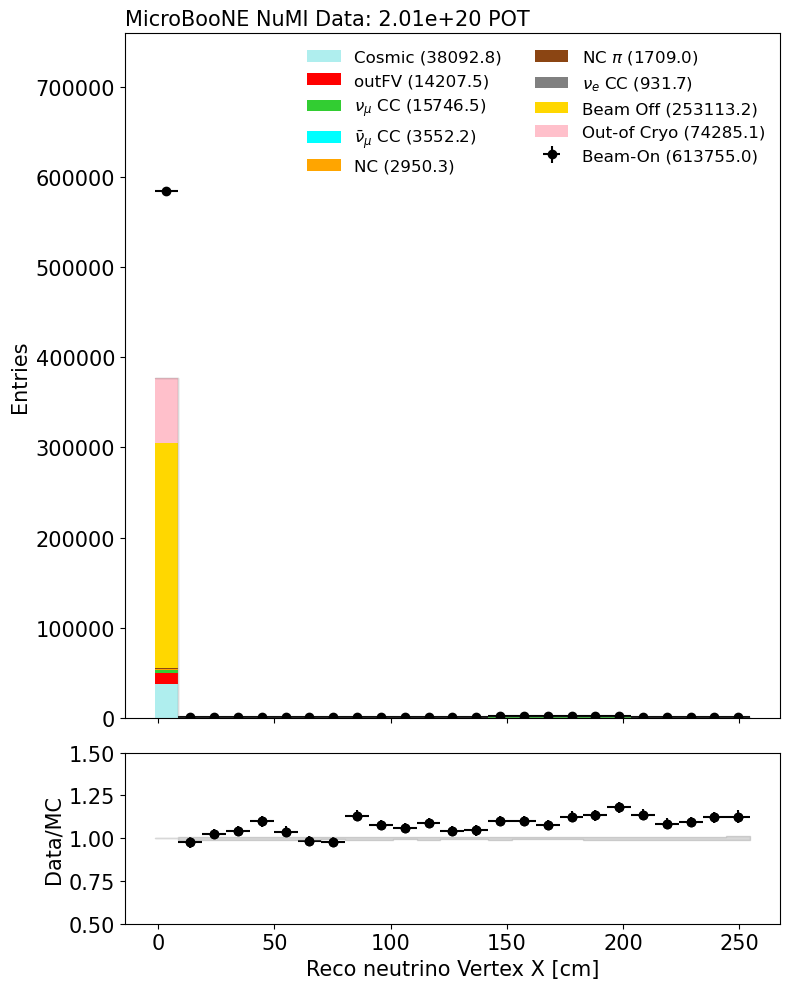

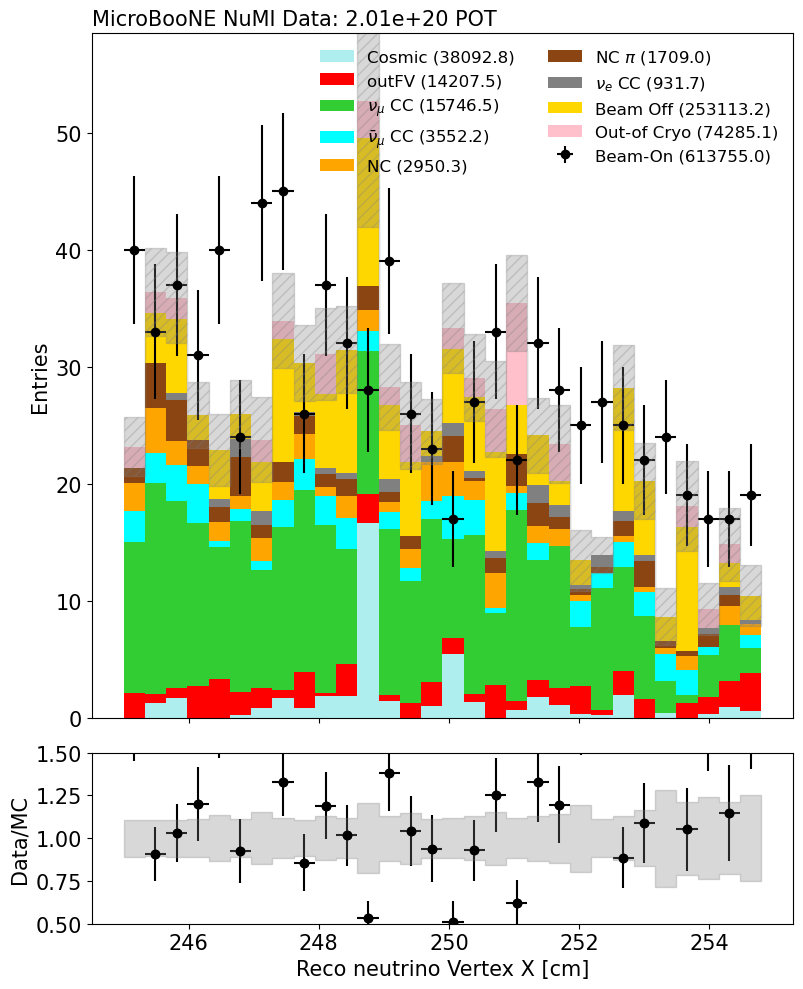

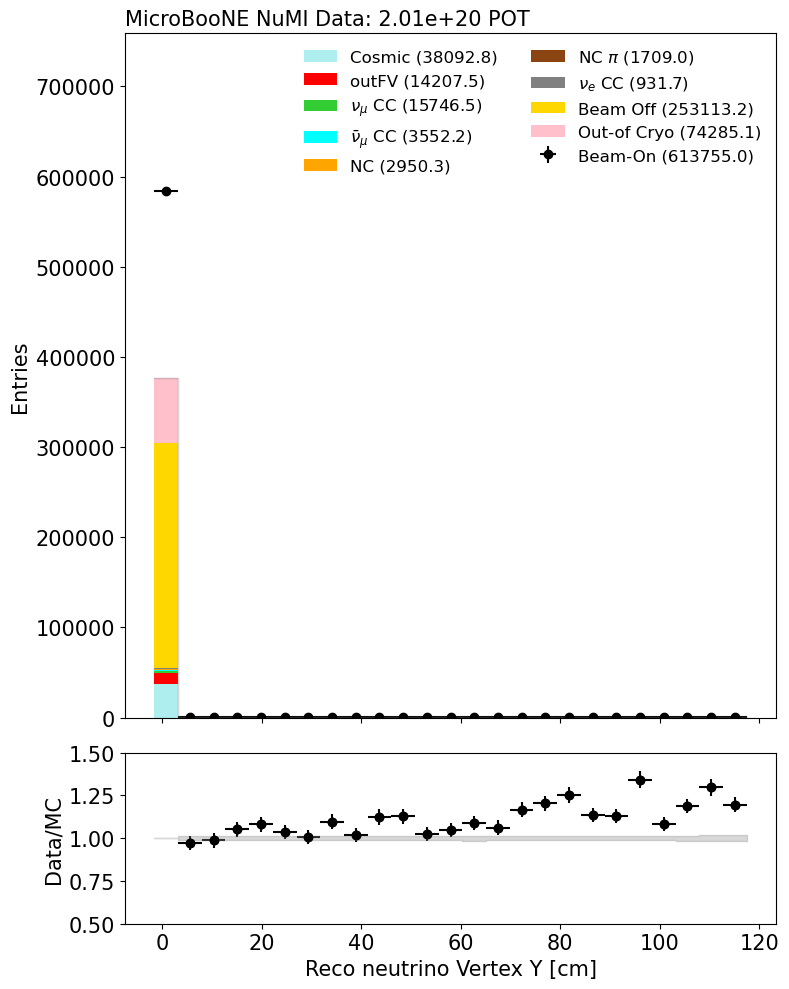

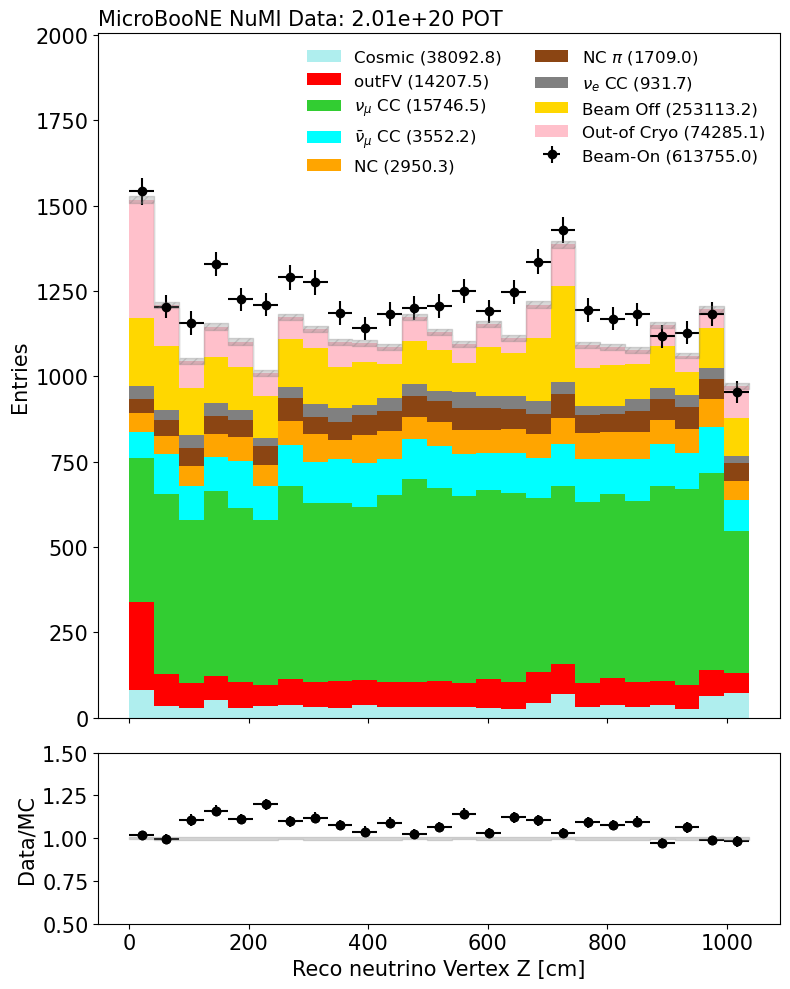

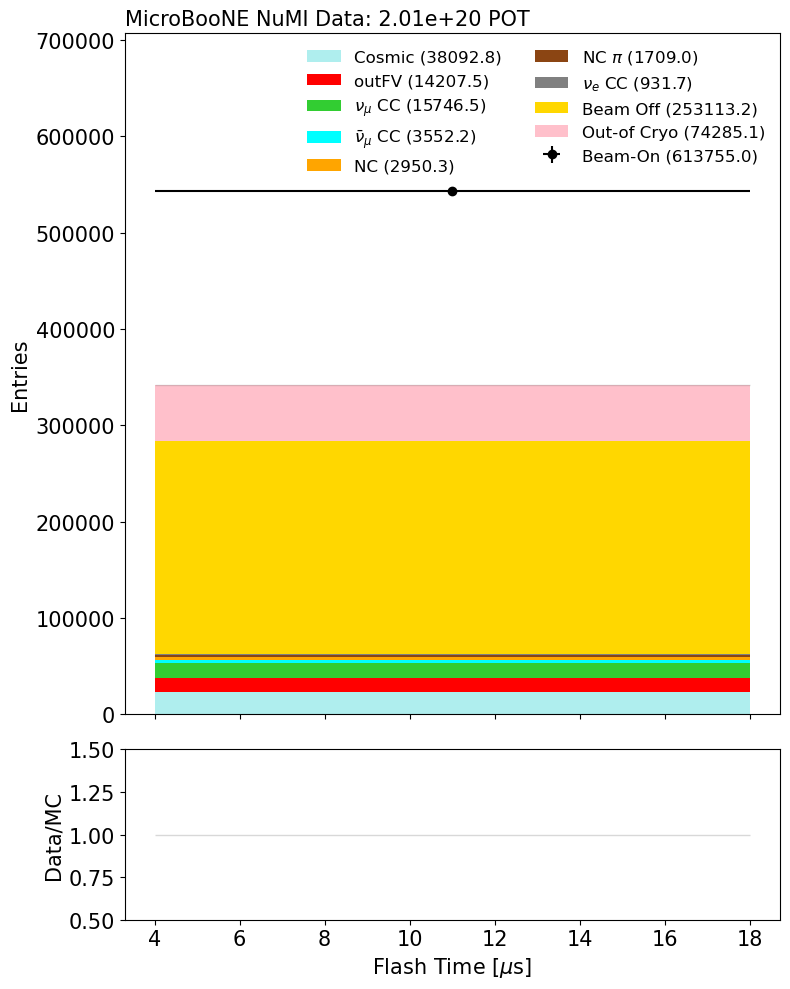

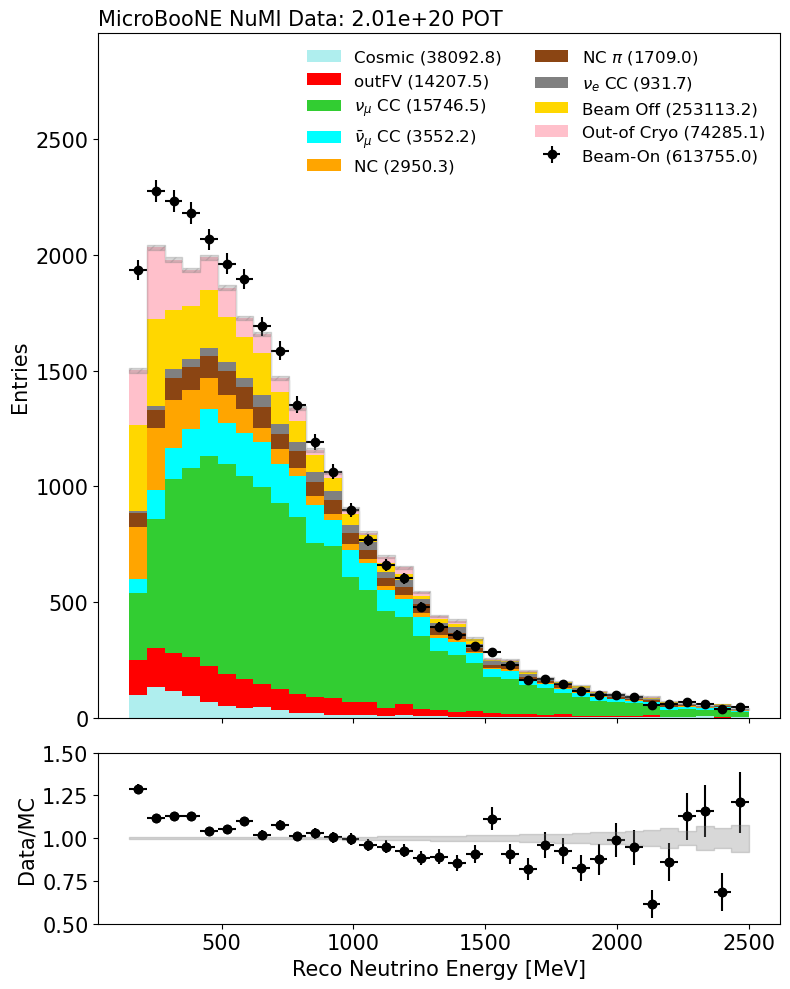

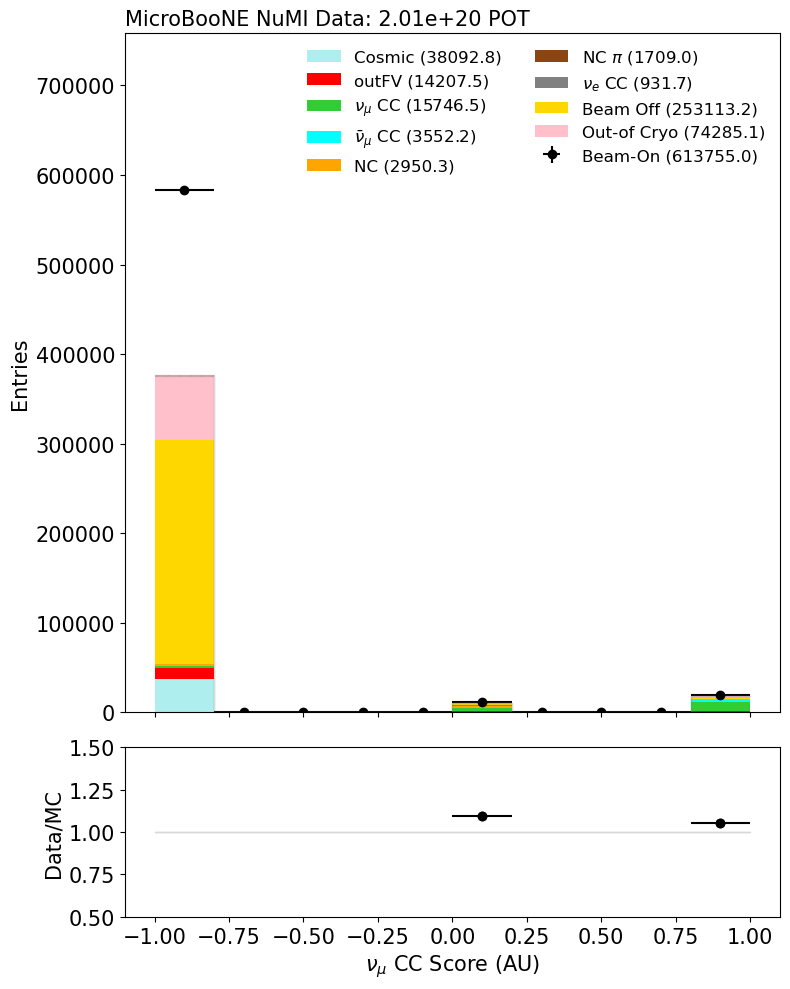

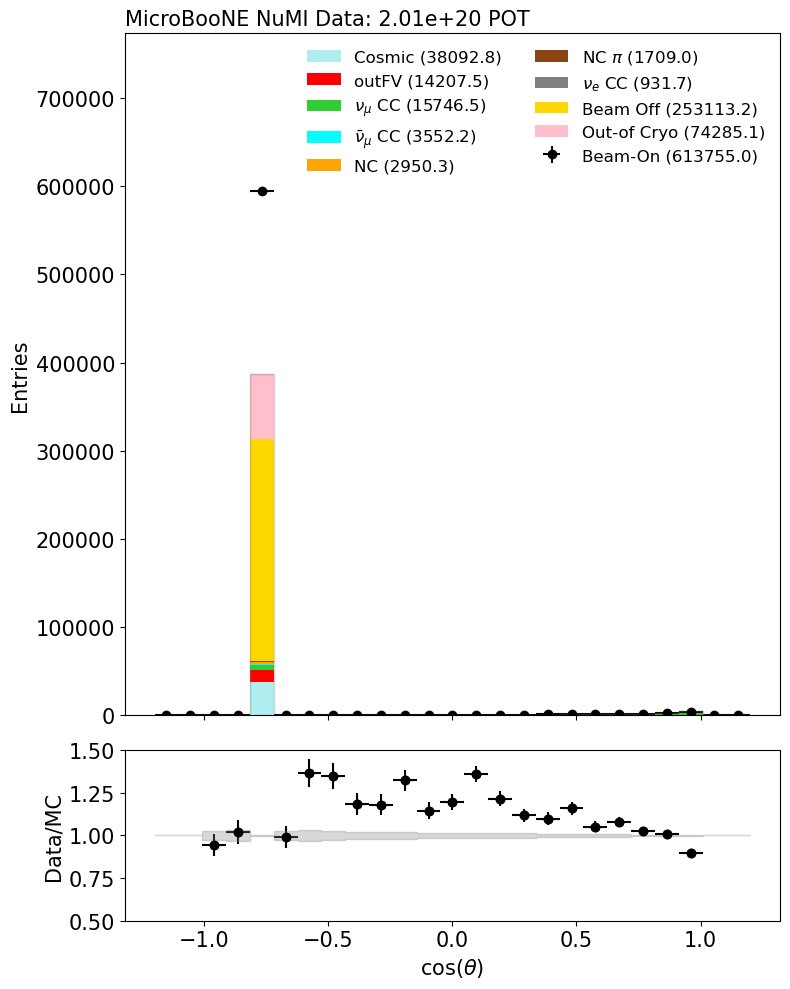


---------- Applying: genNuSelection

[DATA]   30525 entries
[EXT]     3376 entries
[MC]     23139 entries
[DIRT]      2010 entries


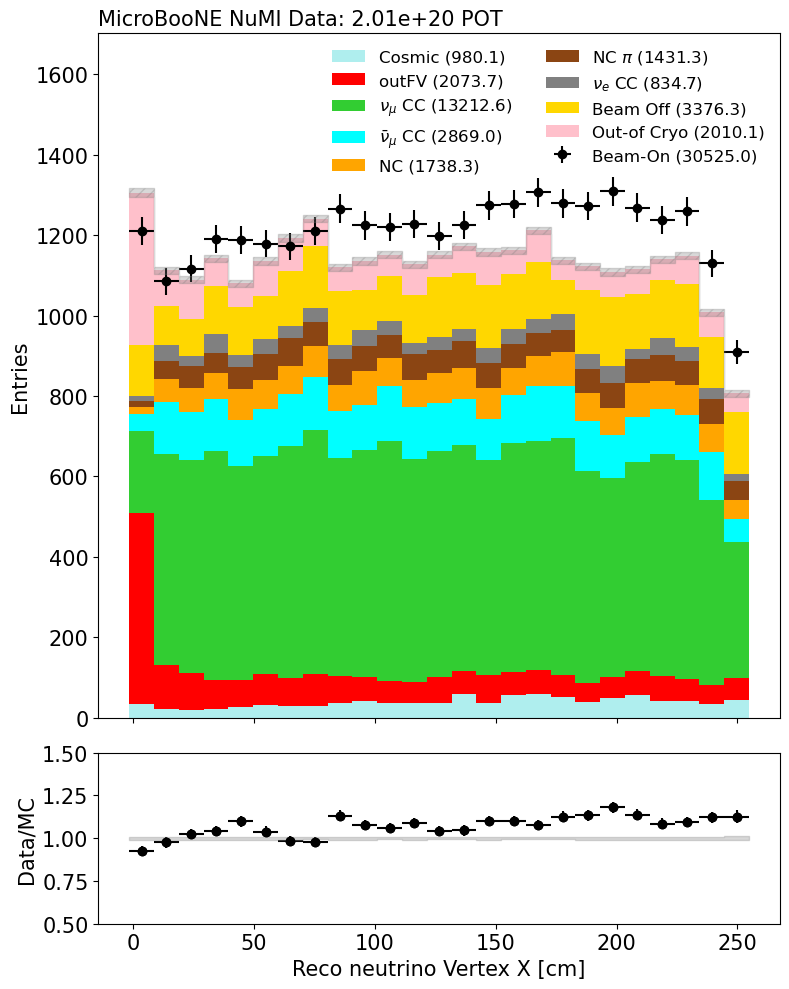

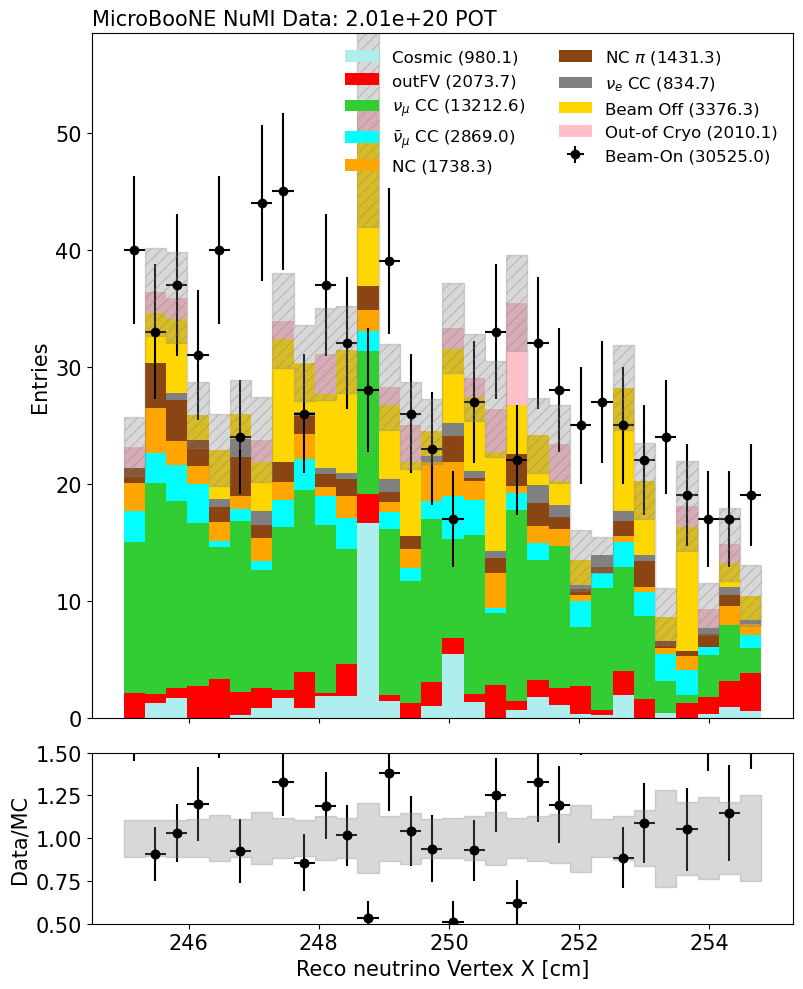

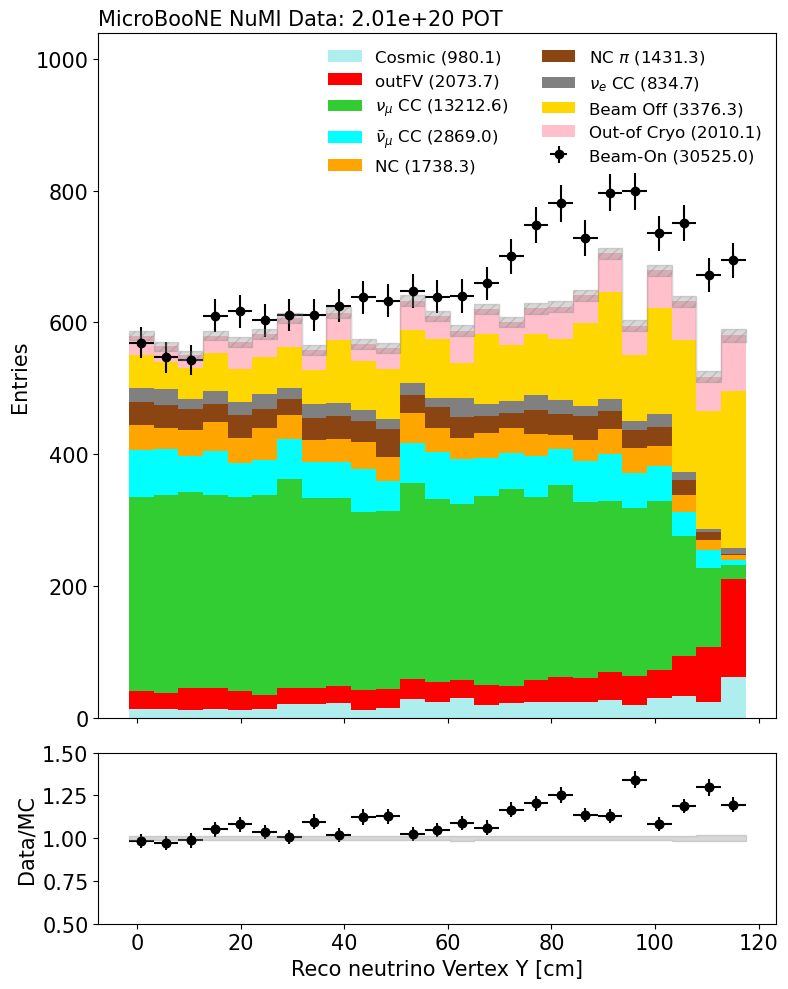

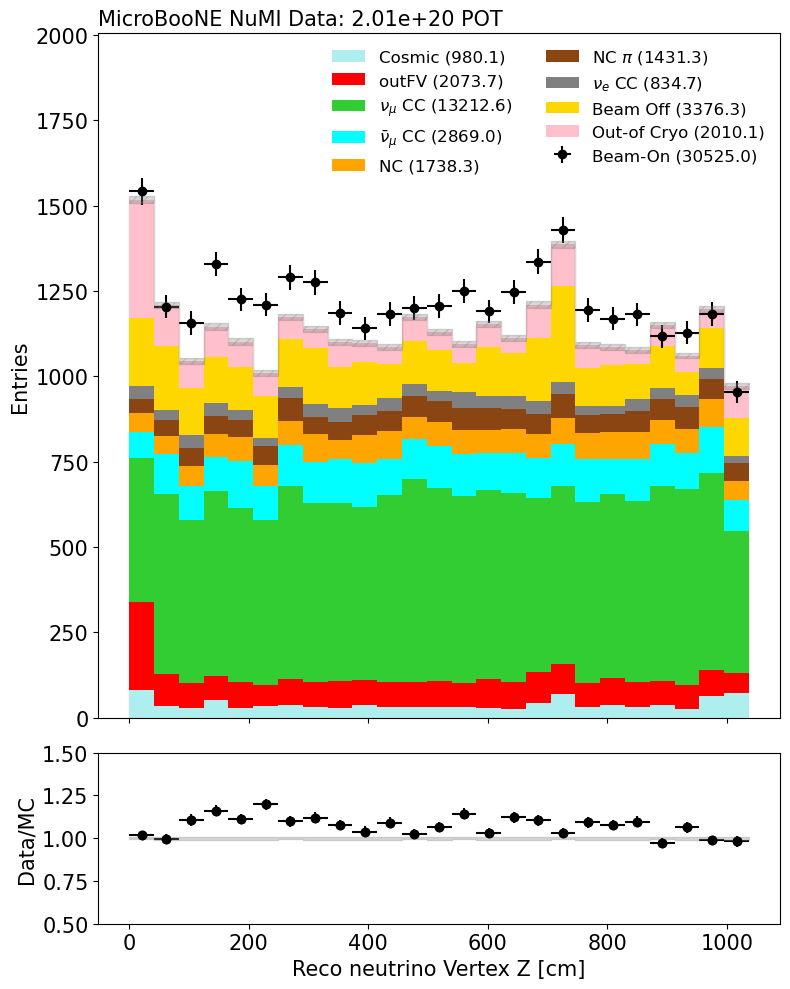

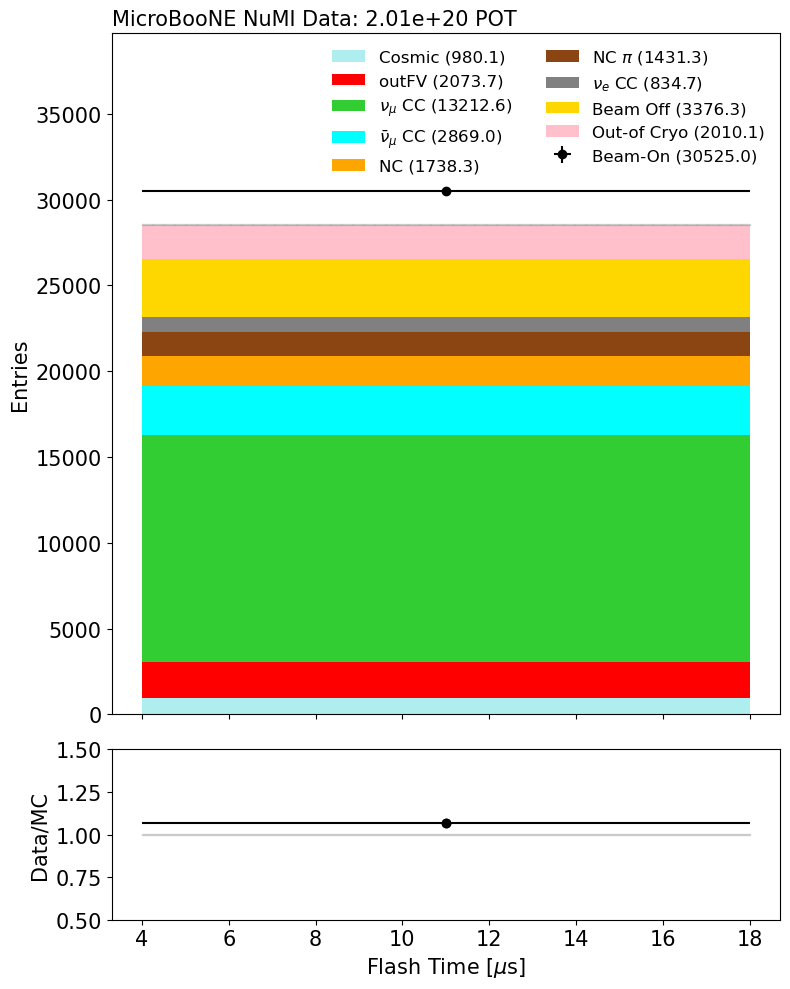

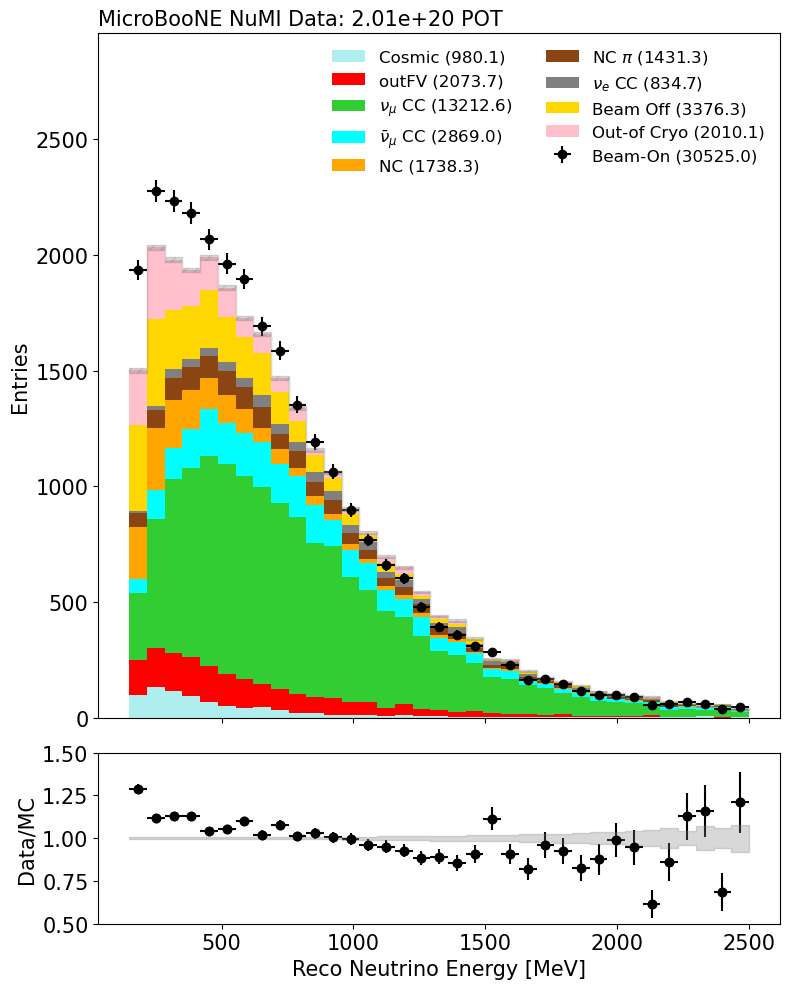

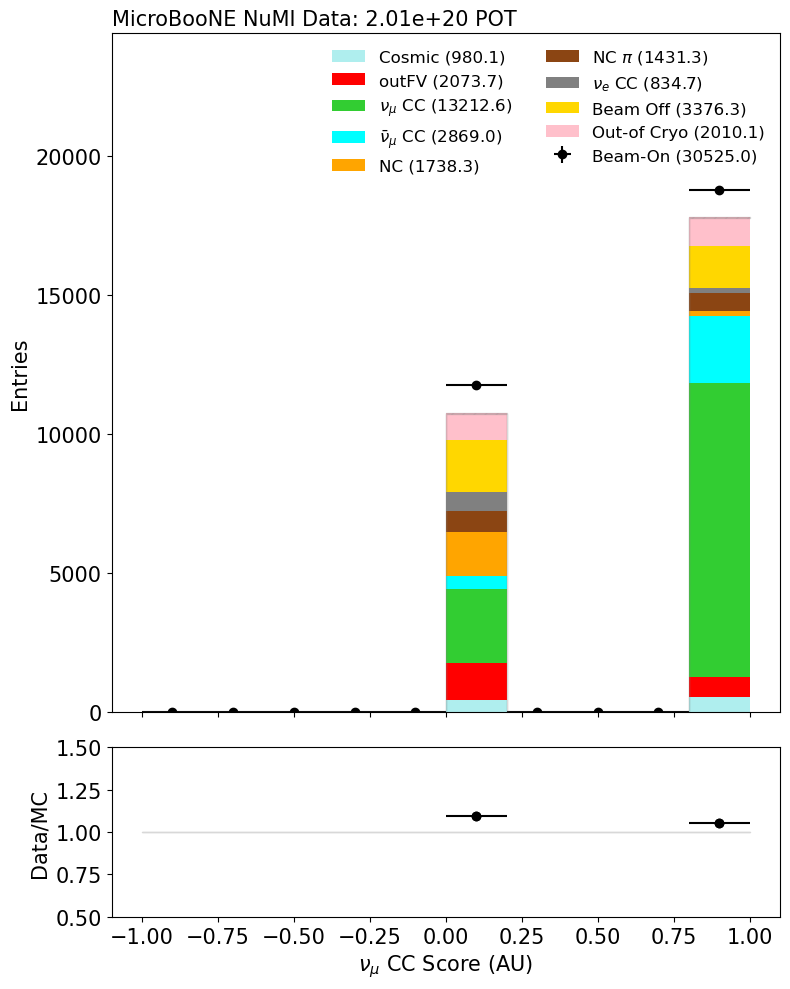

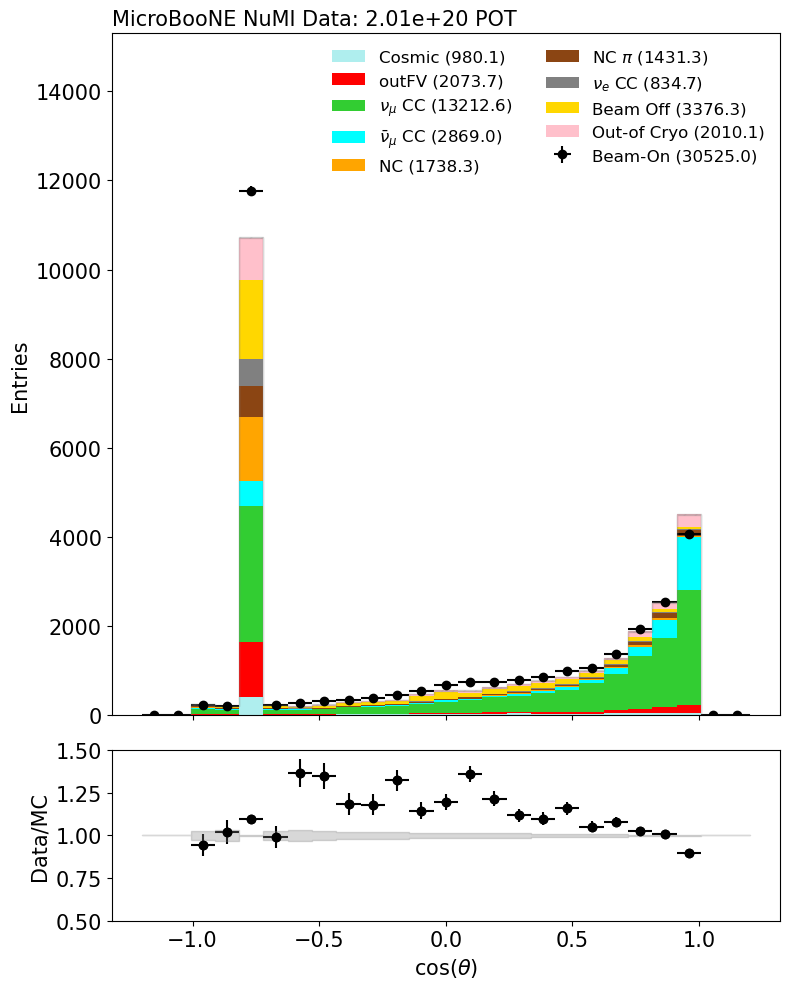


---------- Applying: fiducialVol

[DATA]   28041 entries
[EXT]     2912 entries
[MC]     21865 entries
[DIRT]      1372 entries


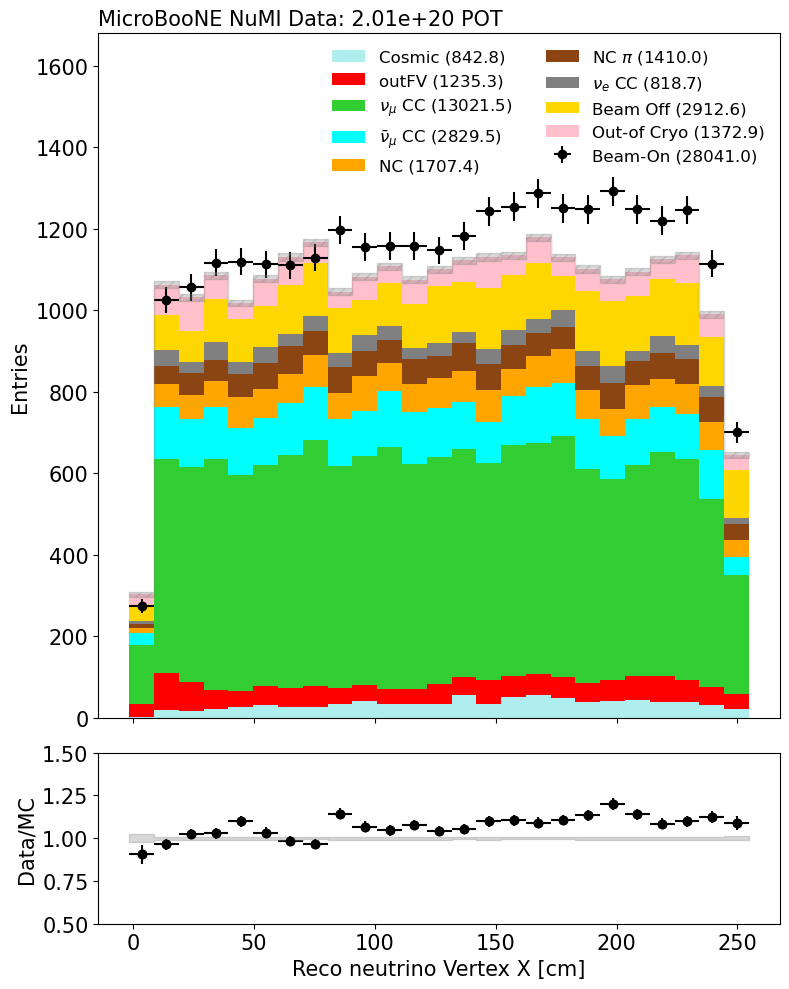

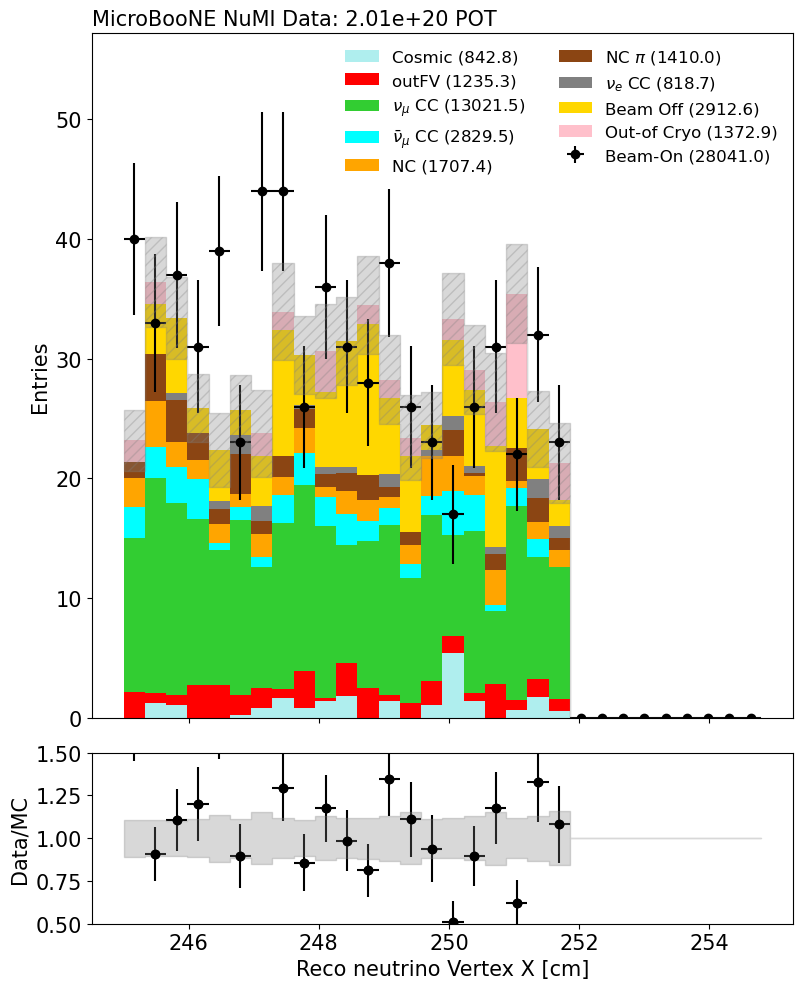

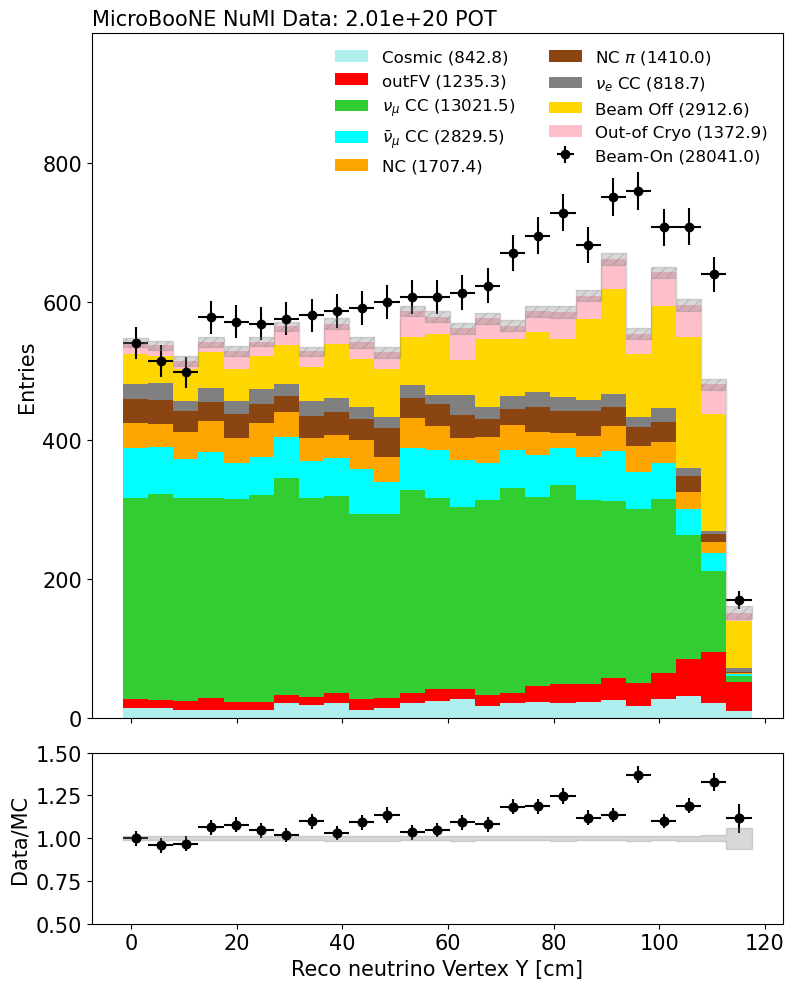

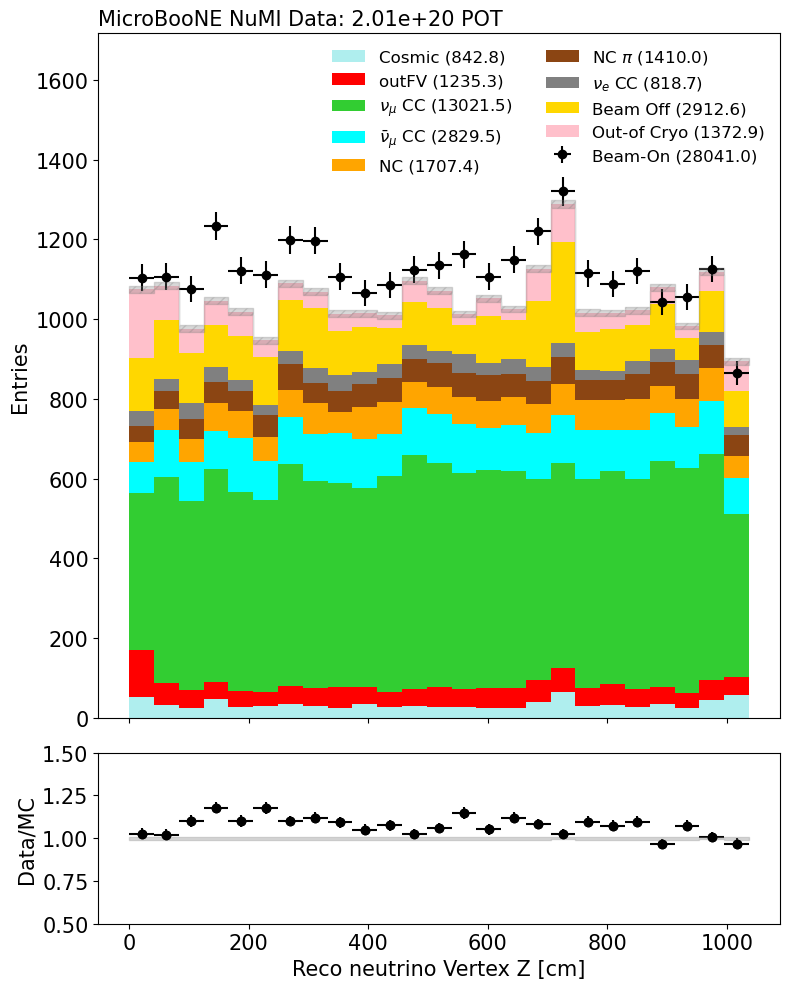

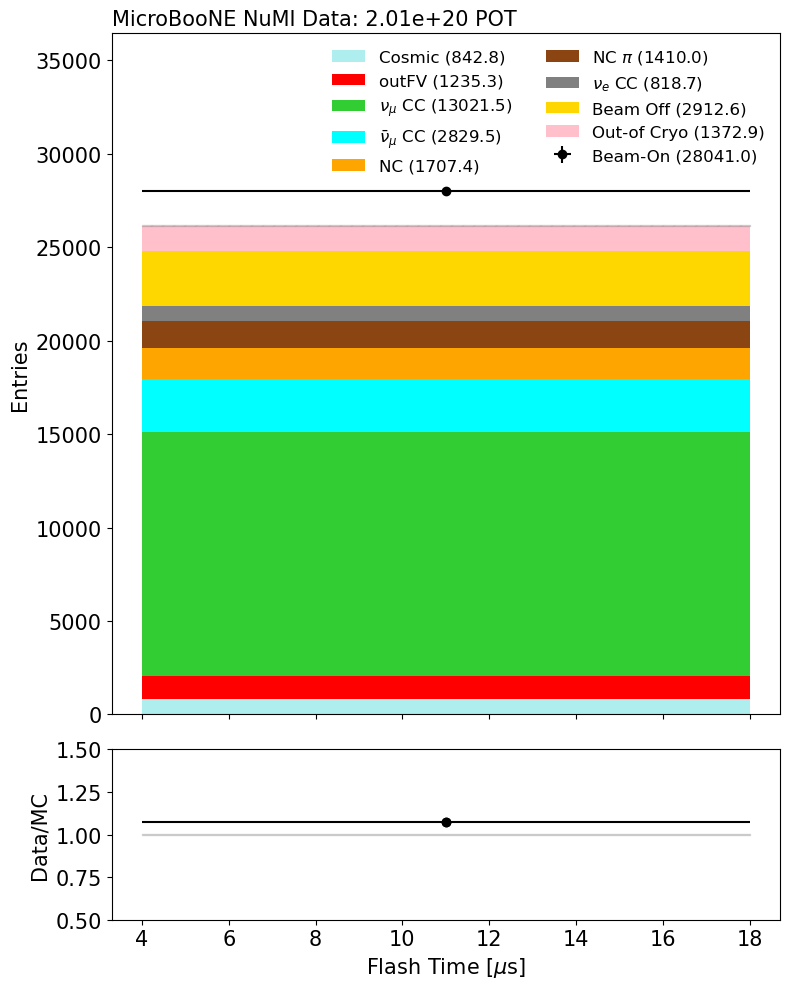

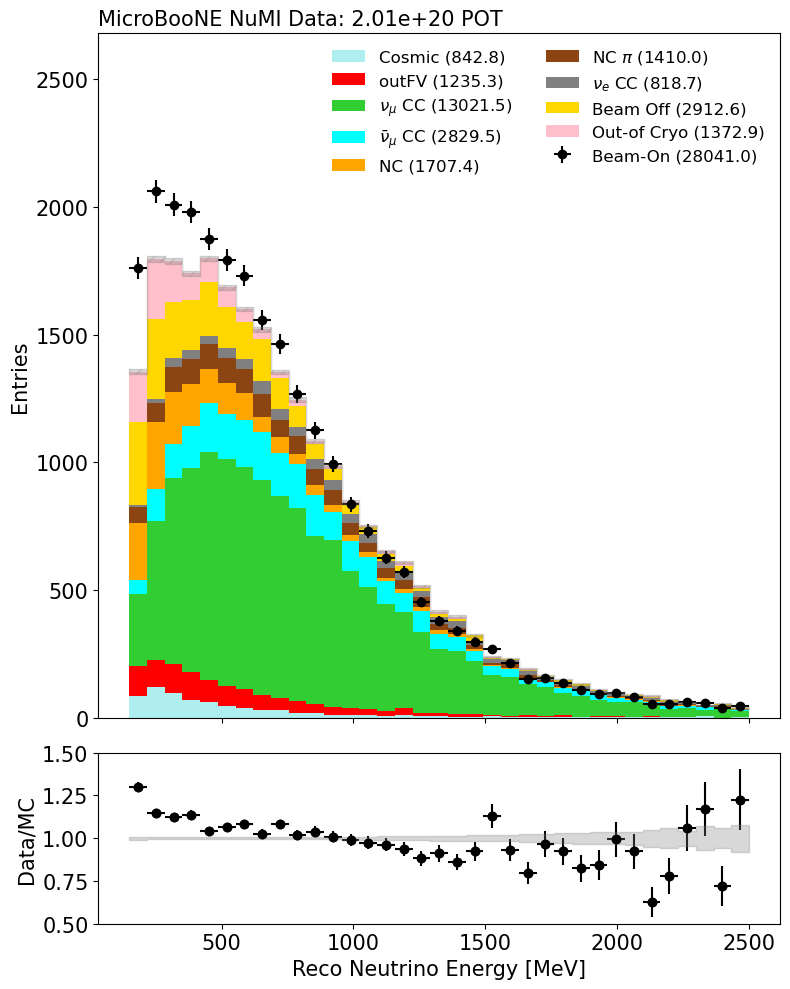

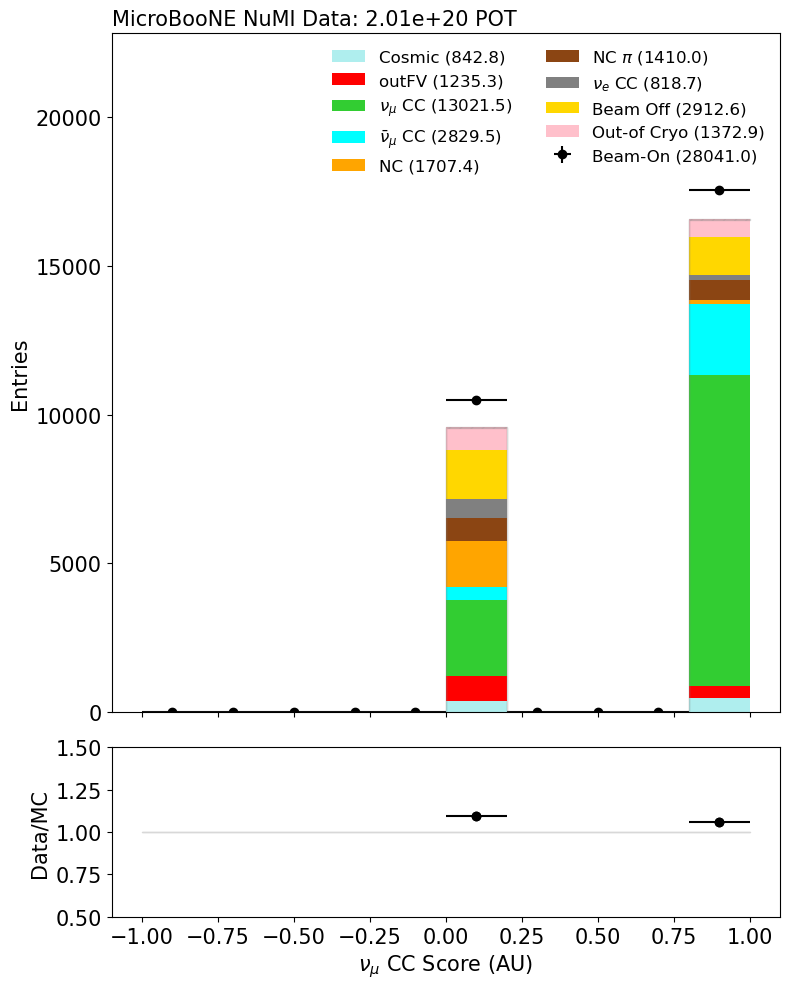

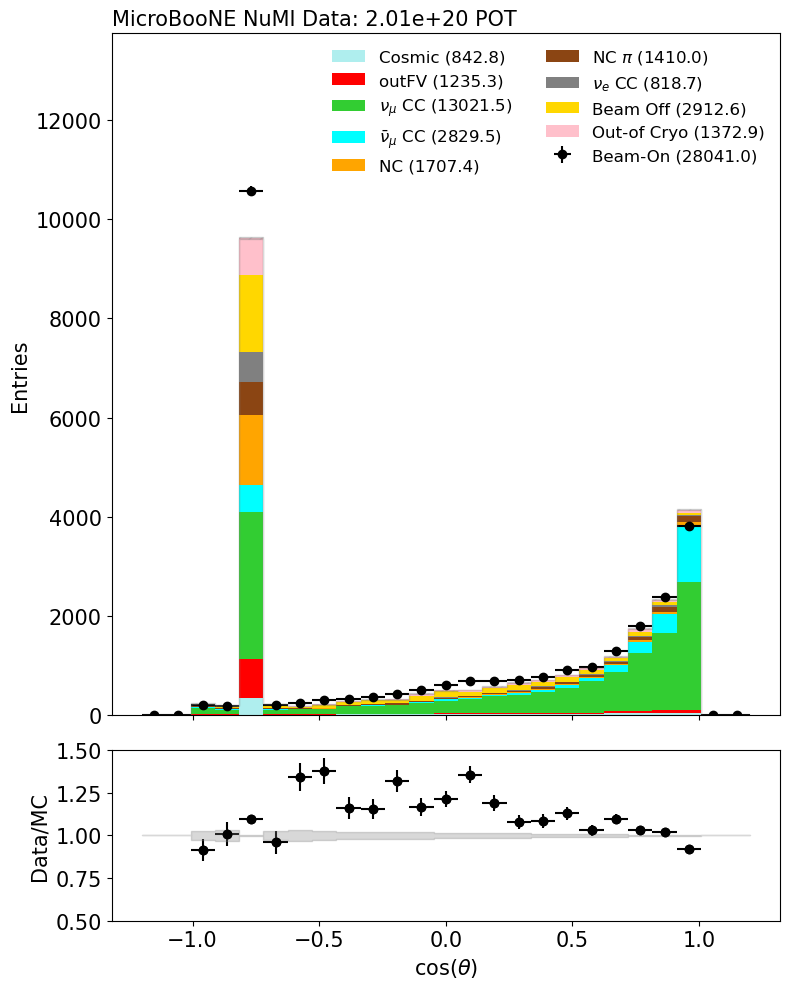


---------- Applying: numuCCCut

[DATA]   17556 entries
[EXT]     1285 entries
[MC]     14687 entries
[DIRT]       593 entries


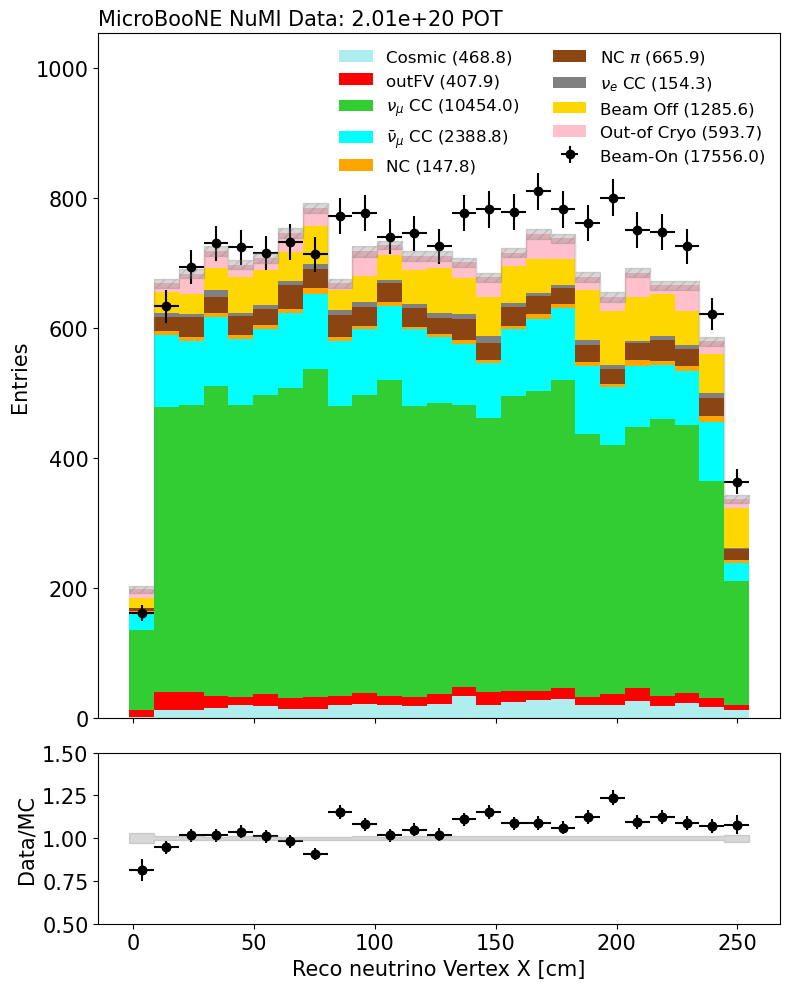

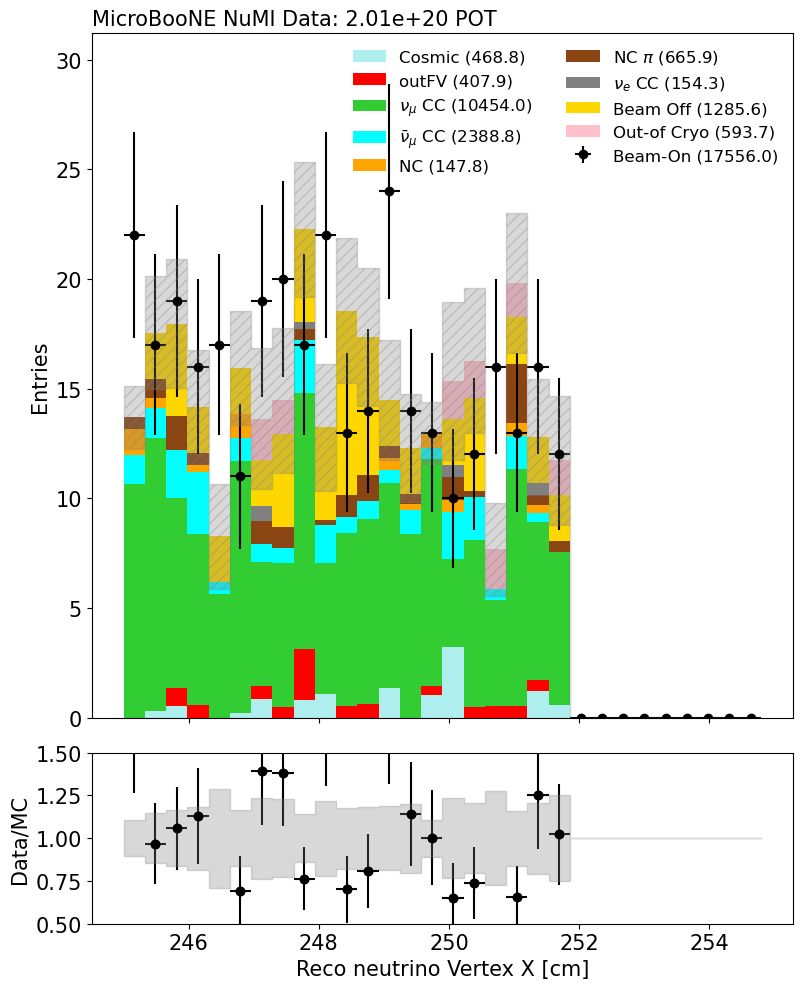

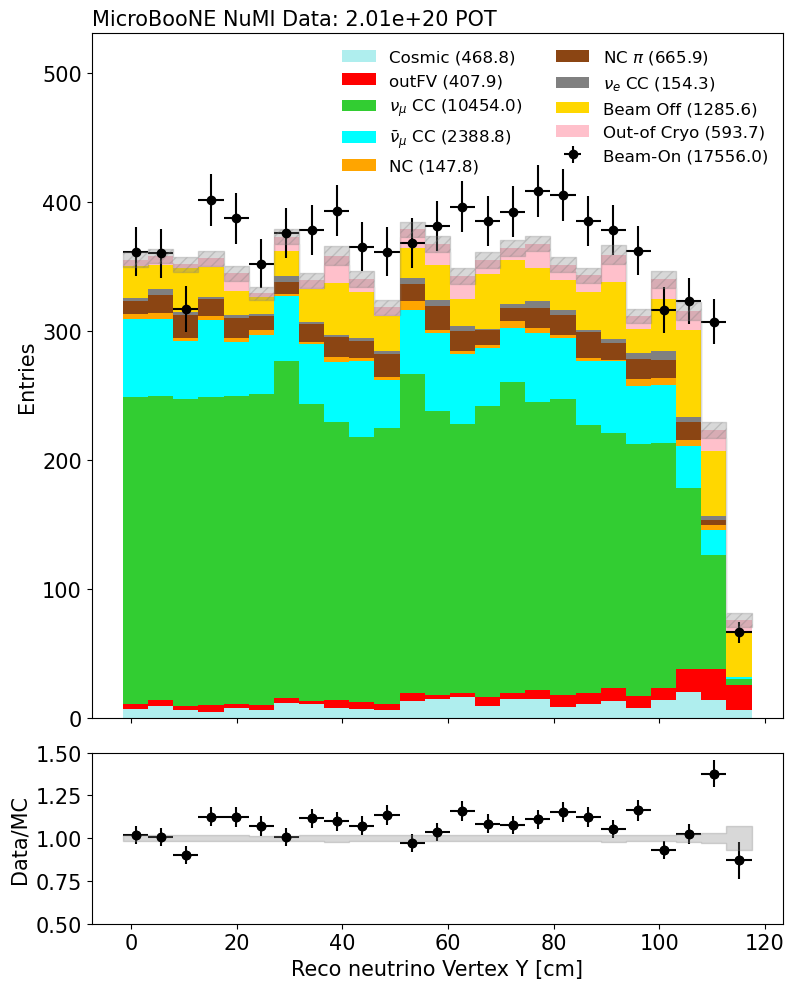

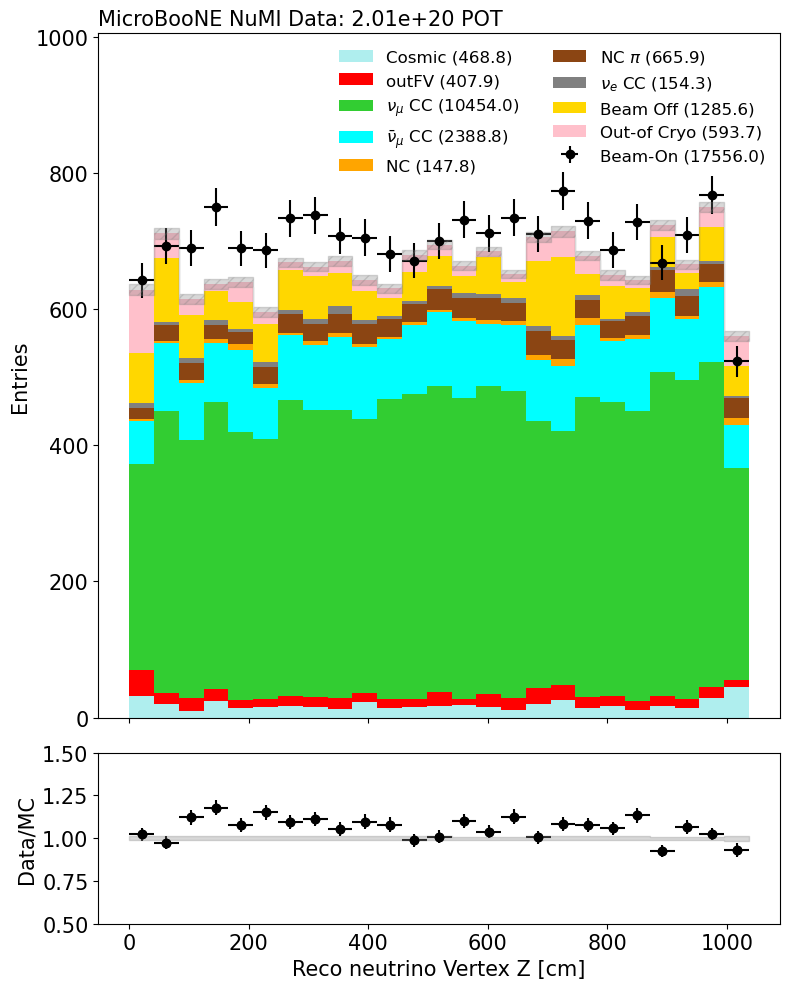

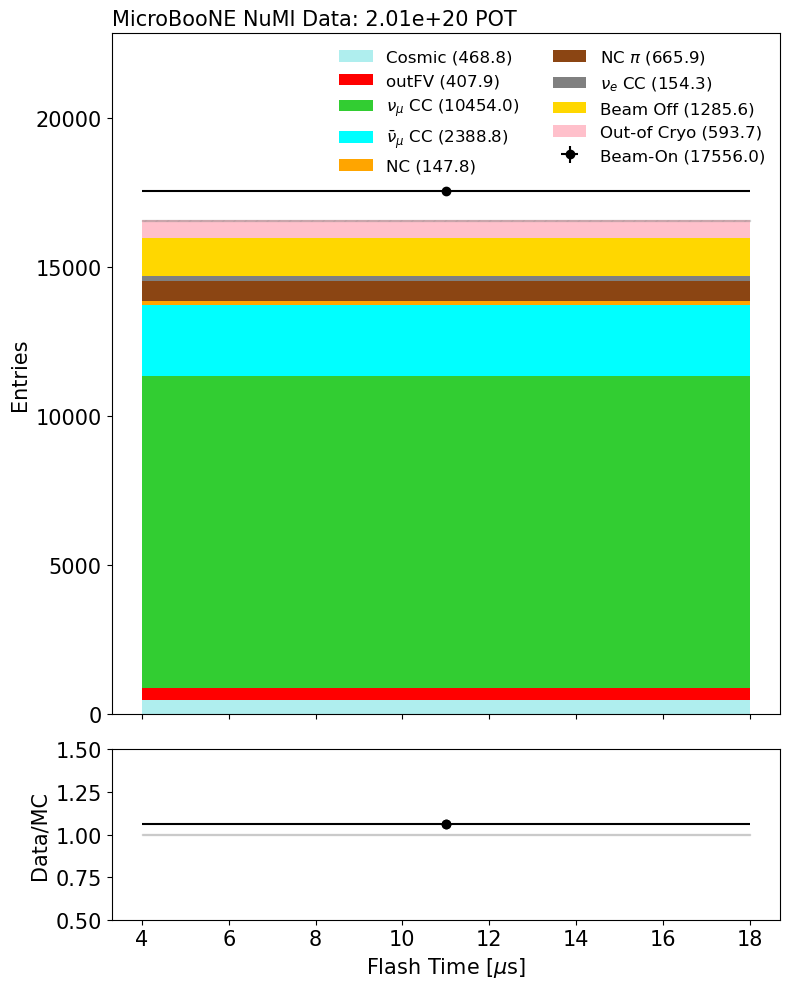

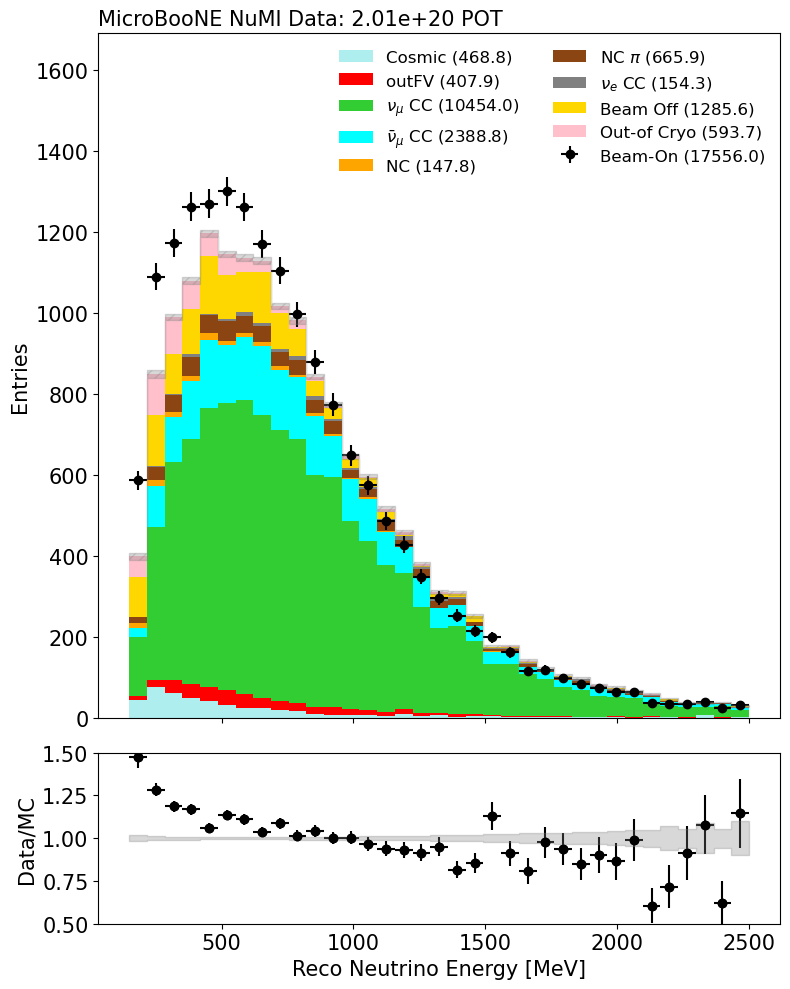

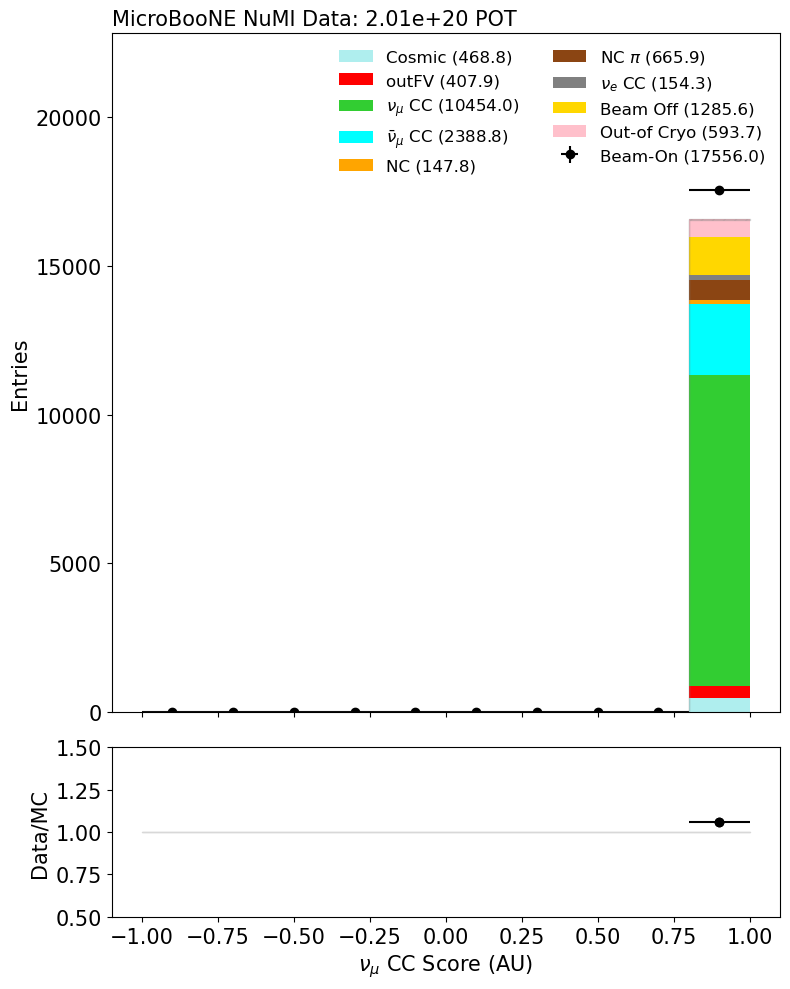

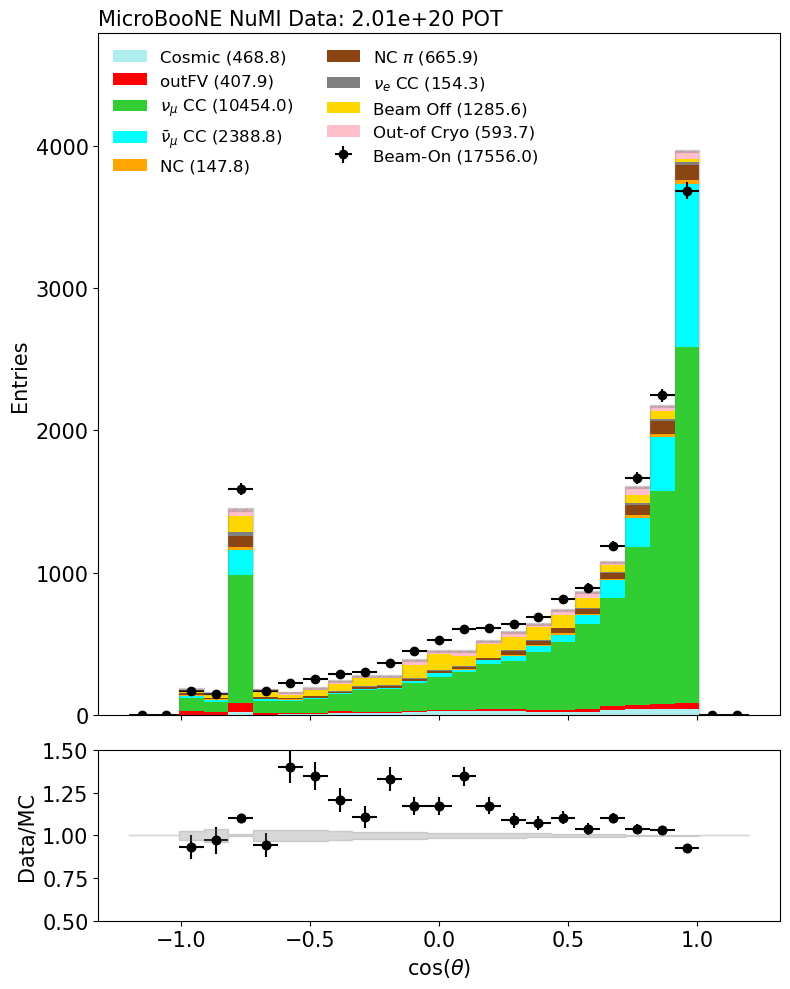


---------- Applying: problematicEnu

[DATA]    8502 entries
[EXT]      859 entries
[MC]      6005 entries
[DIRT]       467 entries


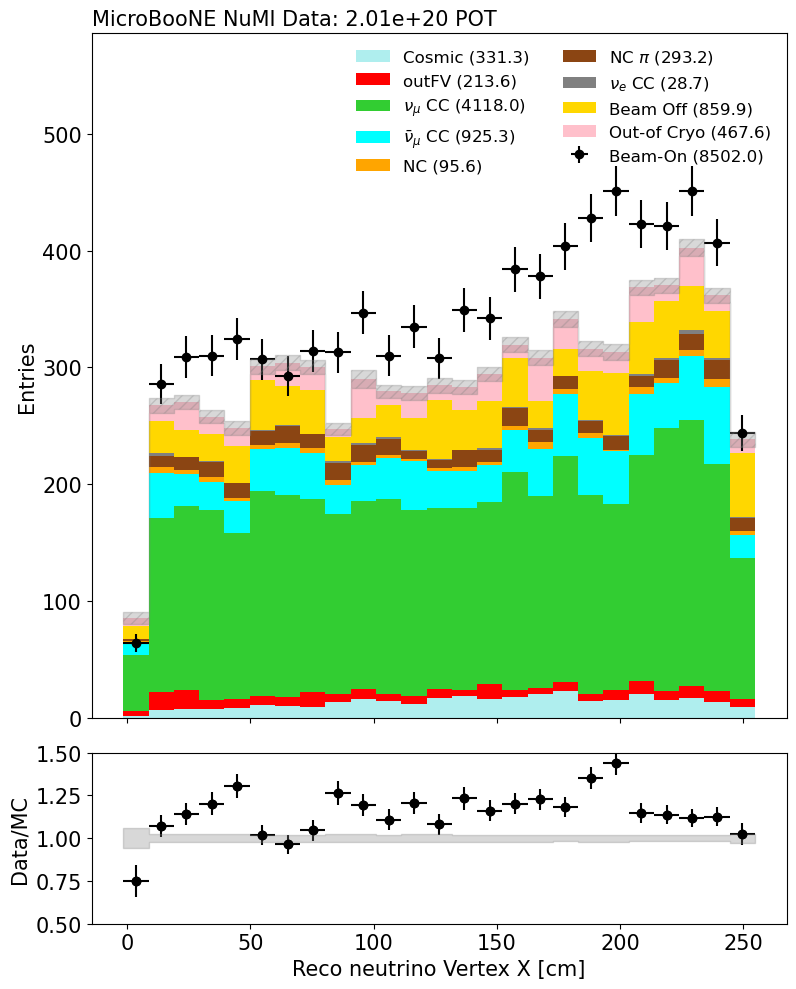

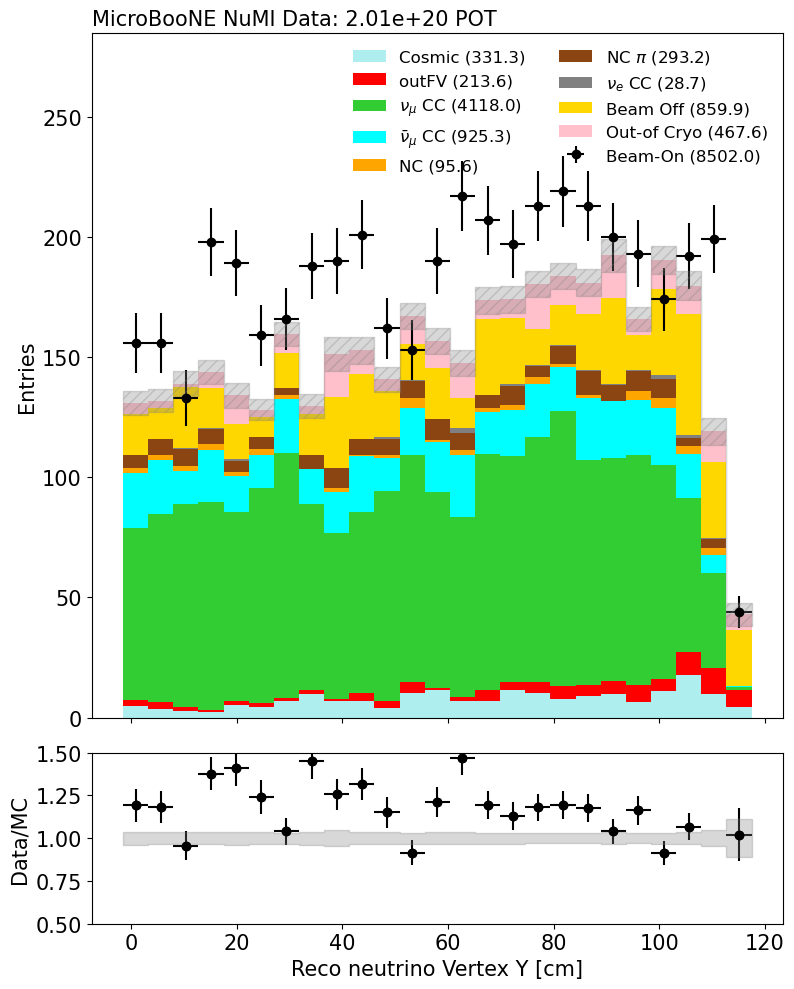

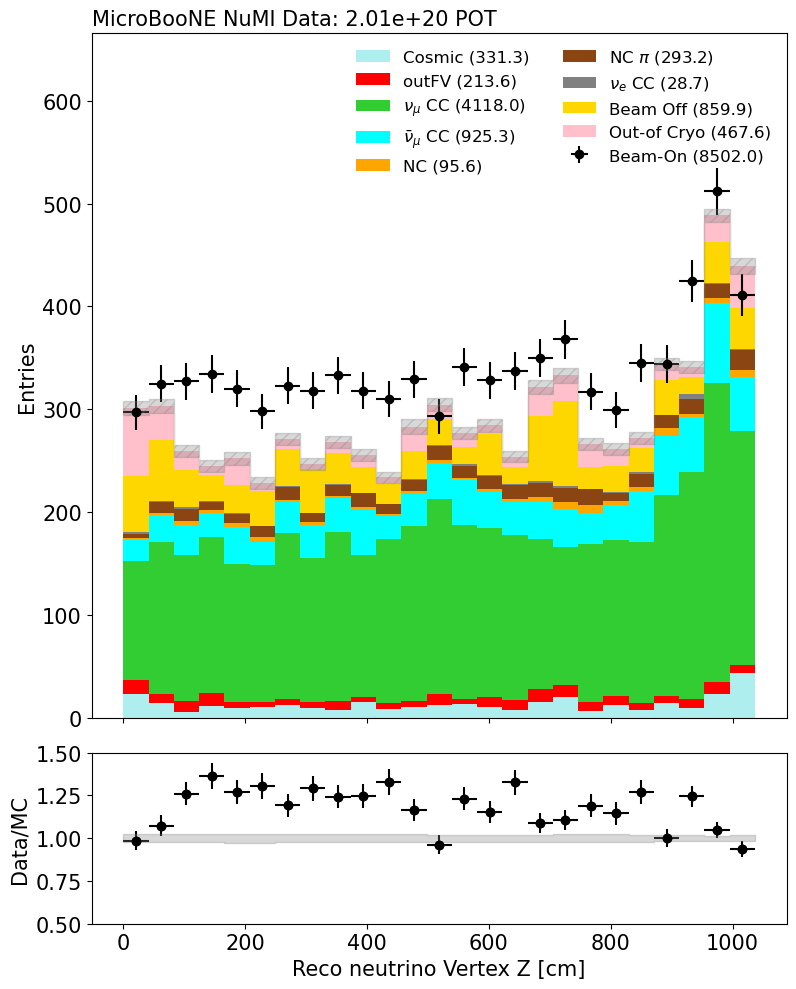

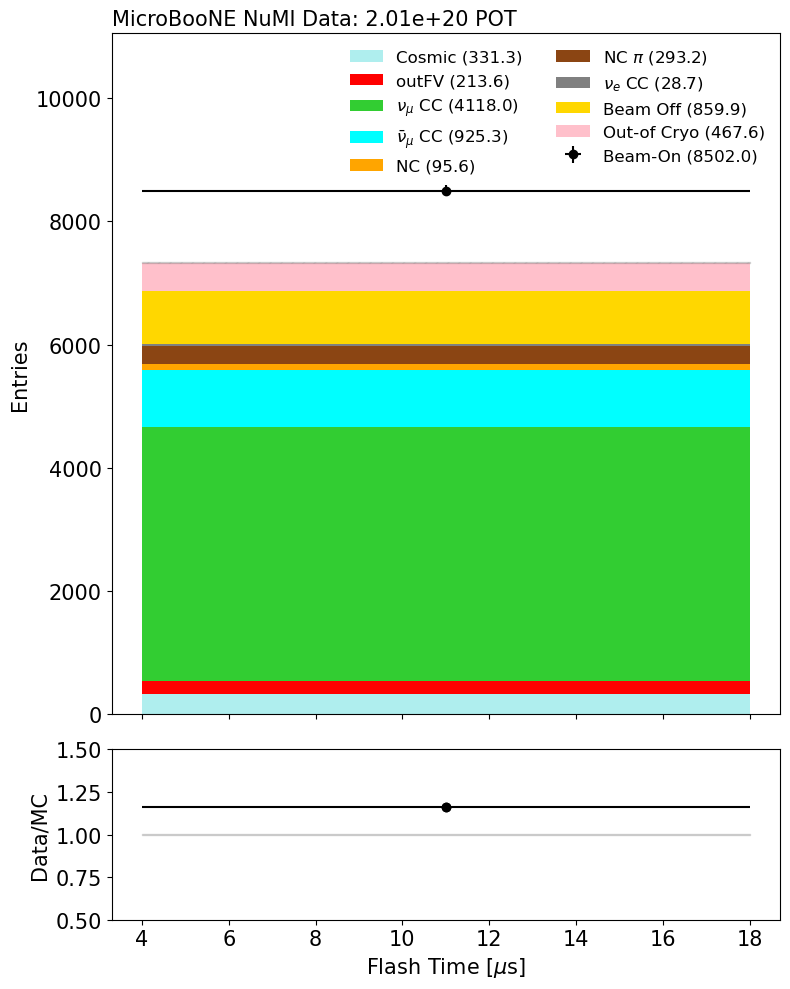

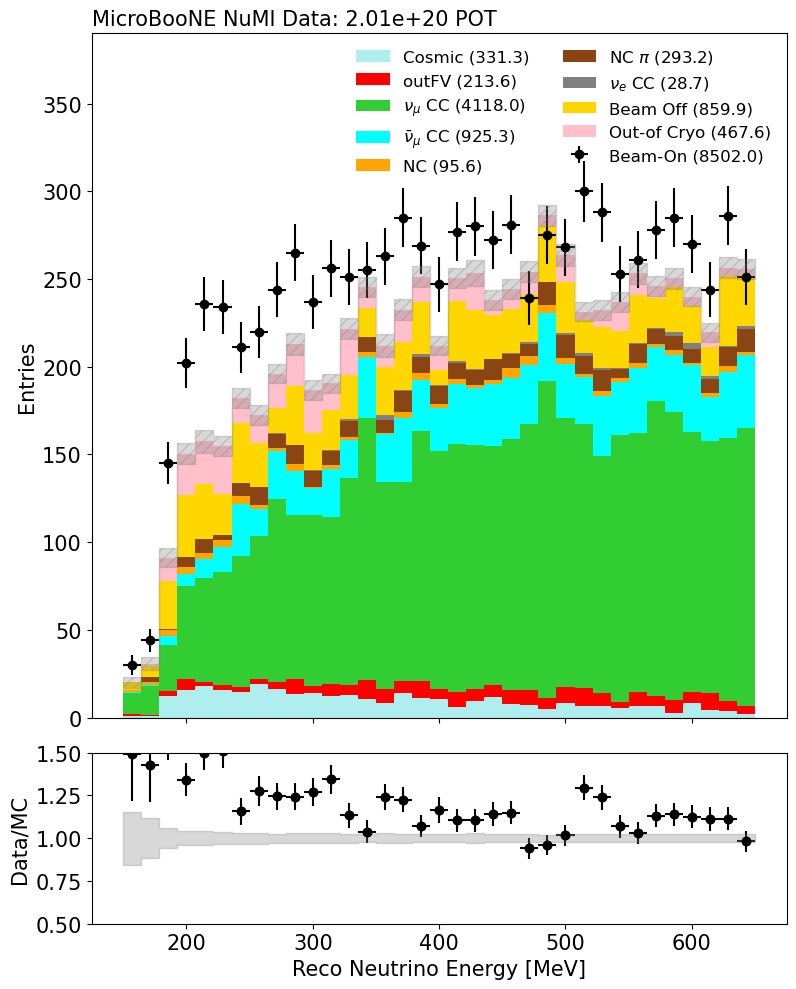

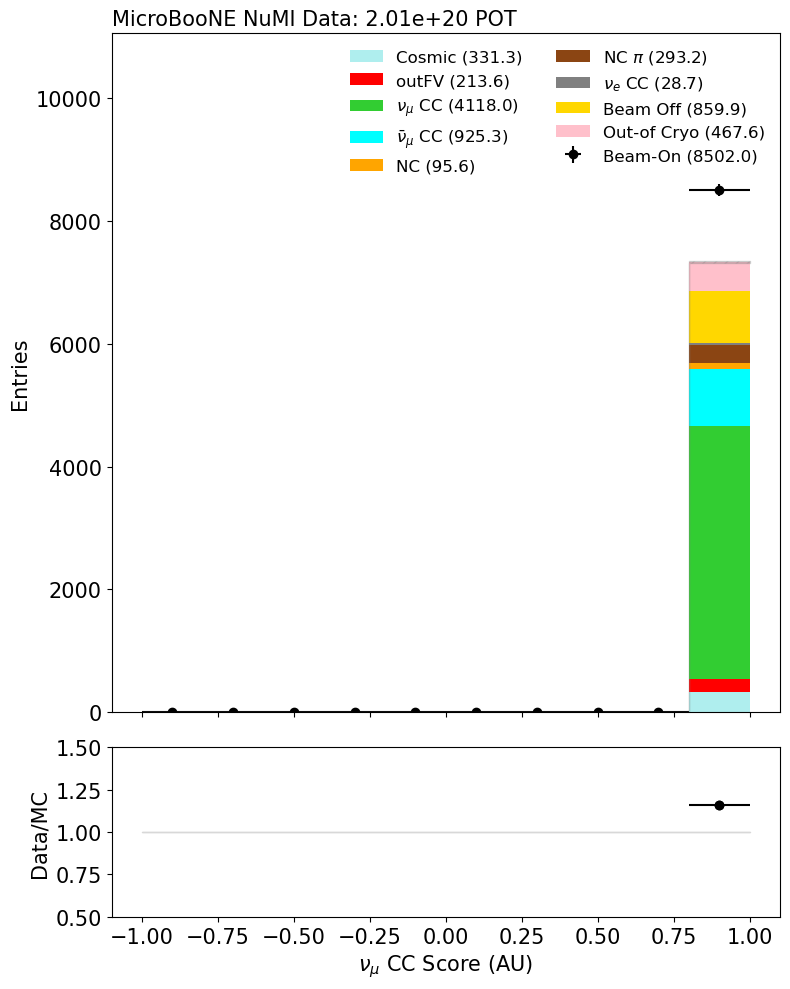

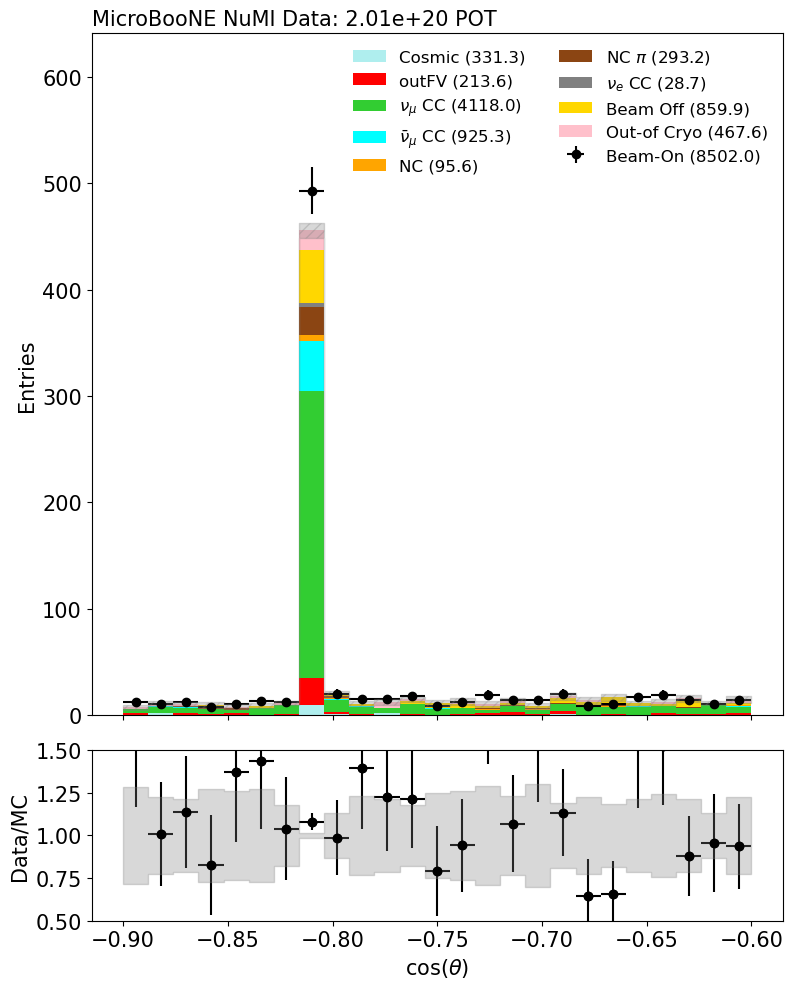

(array([0.53981985, 0.37617052, 0.07491305, 0.00838313, 0.00071346,
        0.        ]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

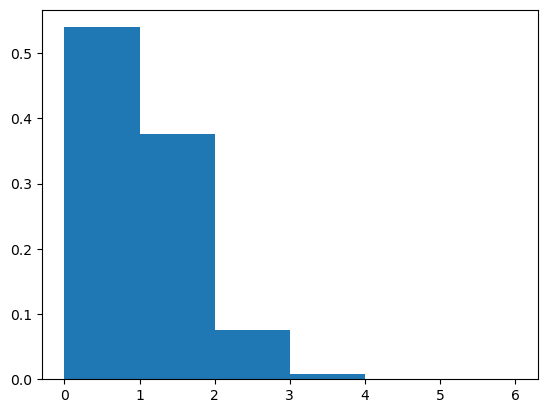

In [28]:
#—————————————————————————————————————————————————————#
# Now apply selection and draw histo and show entries #
#—————————————————————————————————————————————————————#


df_data, df_ext, df_mc, df_dirt = applyCuts('None', df_beam_on, df_ext, df_mc, df_dirt, 'weight_ubtune', True, POT_data=run1_pot_beam_on)
df_data1, df_ext1, df_mc1, df_dirt1 = applyCuts('genNuSelection', df_data, df_ext, df_mc, df_dirt, 'weight_ubtune', True, POT_data=run1_pot_beam_on)
# df_data2, df_ext2, df_mc2, df_dirt2 = applyCuts('recoVtxTrim', df_data1, df_ext1, df_mc1, df_dirt1, 'weight_ubtune', True, POT_data=run1_pot_beam_on)
df_data2, df_ext2, df_mc2, df_dirt2 = applyCuts('fiducialVol', df_data1, df_ext1, df_mc1, df_dirt1, 'weight_ubtune', True, POT_data=run1_pot_beam_on)
df_data3, df_ext3, df_mc3, df_dirt3 = applyCuts('numuCCCut', df_data2, df_ext2, df_mc2, df_dirt2, 'weight_ubtune', True, POT_data=run1_pot_beam_on)
df_data4, df_ext4, df_mc4, df_dirt4 = applyCuts('problematicEnu', df_data3, df_ext3, df_mc3, df_dirt3, 'weight_ubtune', True, POT_data=run1_pot_beam_on, plotCondition='problematicEnu')

plt.hist(df_mc4['Num_Proton'], 6, (0,6), density=True)

Text(0.5, 1.0, 'Reconstructed Proton Multiplicity of Selected MC Sample')

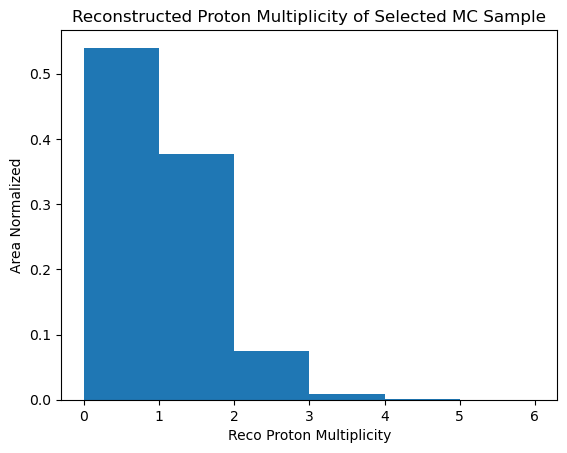

In [29]:
plt.hist(df_mc4['Num_Proton'], 6, (0,6), density=True)
plt.xlabel('Reco Proton Multiplicity')
plt.ylabel('Area Normalized')
plt.title('Reconstructed Proton Multiplicity of Selected MC Sample')

In [30]:
df_mc_angle = df_mc3.query('cos_theta>-0.84 & cos_theta<-0.8')
df_mc_angle['cos_theta'].to_csv('df_run1_mc_cos_theta.csv')


In [33]:
# Storing Selected mixed numu & anti-numu sample 
df_mc3.to_hdf('dfs/df_run1_mc_mixed_numu_numubar.hdf5', key='df', mode='w')
df_data3.to_hdf('dfs/df_run1_data_mixed_numu_numubar.hdf5', key='df', mode='w')
df_dirt3.to_hdf('dfs/df_run1_dirt_mixed_numu_numubar.hdf5', key='df', mode='w')
df_ext3.to_hdf('dfs/df_run1_ext_mixed_numu_numubar.hdf5', key='df', mode='w')

/var/folders/fv/hd3tpwx94s5bkn0_24vqg4wc0000gn/T/ipykernel_687/899609062.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['truth_pdg', 'RSE'], dtype='object')]

  df_mc3.to_hdf('dfs/df_run1_mc_mixed_numu_numubar.hdf5', key='df', mode='w')
/var/folders/fv/hd3tpwx94s5bkn0_24vqg4wc0000gn/T/ipykernel_687/899609062.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['truth_pdg', 'RSE'], dtype='object')]

  df_dirt3.to_hdf('dfs/df_run1_dirt_mixed_numu_numubar.hdf5', key='df', mode='w')
